## A Tale of Two Problems, Part 1: Real World Experimental Data

### Step 0: Evaluate correlation matrix for raw data

/tmp/ipykernel_47182/2580262278.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr().abs()


<Axes: >

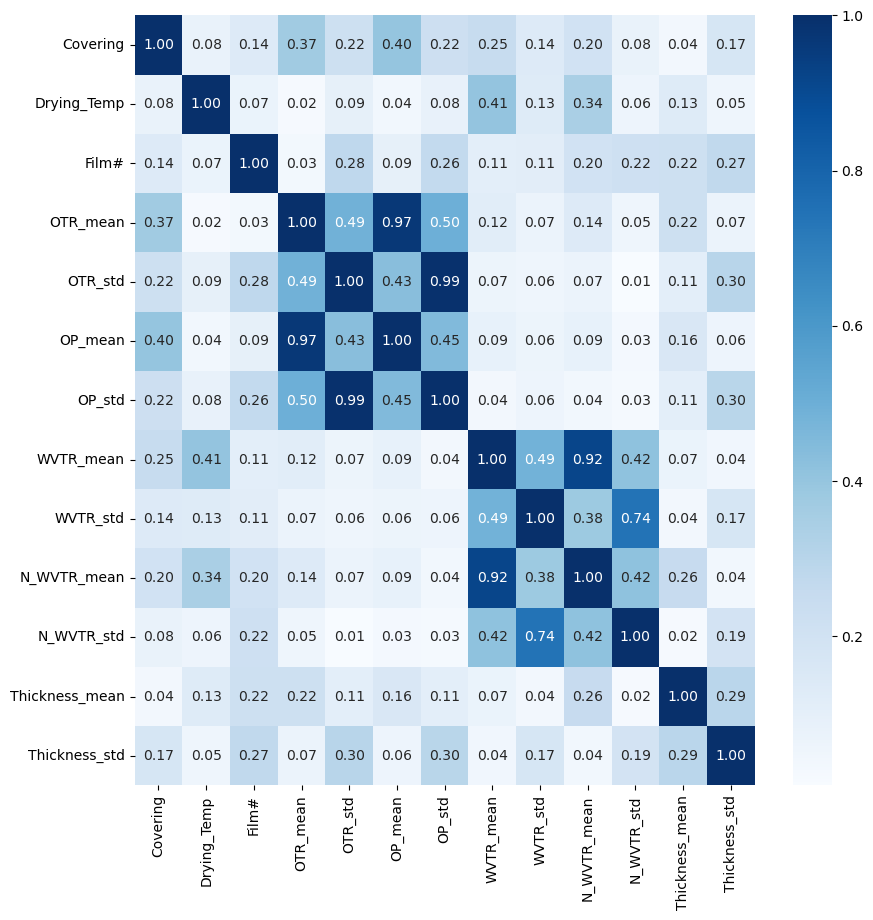

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
data = pd.read_csv('./load_data/Aggregated_Data_RH50.csv')
# Generatea and plot the correlation matrix for data
corr = data.corr().abs()
fig, ax = plt.subplots(figsize=(10,10),dpi=100)
sns.heatmap(corr,ax = ax, cmap='Blues', annot=True, fmt='.2f')

### Step 1: Handle numerical data stored as strings and categorical data via conversion to fractions and one-hot encoding
- Find the rows that contain slashes: indicative of multiple components
- The data is split into two parts, one with '/' in the name and the other without '/' in the name. Evaluate overlap and unique elements

In [2]:
def find_row_indices_with_slash(x):
    if '/' in x:
        return True
    else:
        return False
    
# example usage 
slash_rows = data['Name'].apply(find_row_indices_with_slash)
no_slash_rows = [not slash_rows[i] for i in range(len(slash_rows))]
slash_data, no_slash_data = data.loc[slash_rows,:], data.loc[no_slash_rows,:]

from itertools import chain

def split_strings_with_slash(x):
    try:
        temp = x.split(' ')[1]
    except IndexError:
        temp = x
    temp_split = temp.split('/')
    return temp_split

_split = slash_data['Name'].apply(split_strings_with_slash).to_numpy()

_all = list(chain.from_iterable((_split[i]) for i in range(len(_split))))

_set_all_slash = set(_all)
_set_noslash = set(no_slash_data['Name'])

unique_slash = _set_all_slash - _set_noslash
unique_noslash = _set_noslash - _set_all_slash
common = _set_noslash & _set_all_slash

print('Unique multi-component: ', unique_slash, '\nUnique single component: ', unique_noslash, '\nCommon: ', common)

Unique multi-component:  {'ChNF-Sugino', 'Ca-150-3', 'Al', 'ChNF-M-150-3', 'ChNF-L-120-3', 'PLA-3L', '50CA', '30CA-120-3', 'ChNF-CP-2-100-3', 'Ca-120-3', '10CA', 'ChNC-CS', 'ChNF-L-UH', 'Ca-1-20', 'PLA-15L', '20CA', 'Ca', '30CA', '20CA-120-3', 'PLA-6L', 'ChNF-M-120-3', '100CA', 'PLA-6L-120-3'} 
Unique single component:  {'ChNC-CP', 'TOCN-COOCa', 'Earthfirst PLA', 'TOCN-COONa'} 
Common:  {'PLA', 'ChNF-CP-100-3', 'CNC', 'ChNF-M', 'ChNF-CP', 'ChNF-H', 'ChNF-EL', 'Chitosan', 'ChNF-CS', 'ChNF-CP-2', 'ChNF-L'}


- Convert information from 'Name' column to numerica data. Create fractions based on component ratio and one hot encode variables for which there is not ratio information

In [3]:
num_new_columns = len(unique_slash) + len(unique_noslash) + len(common)
print('Number of new columns: ', num_new_columns)

new_col_values = {_key:[] for _key in list(unique_slash)+list(unique_noslash)+list(common)}

def get_new_column_vals(x):
    temp = x.split(' ')
    # Need to fill dictionary new_col_values with the fractional values of the first two components of comps and with one hot encoding for the third component
    if len(temp) == 1:
        # No space
        comp = temp[0].split('/')
        if len(comp) == 1:
            new_col_values[temp[0]].append(1)
            for key in new_col_values.keys():
                if key != temp[0]:
                    new_col_values[key].append(0)
        else:
            for key in new_col_values.keys():
                if key == comp[0]:
                    new_col_values[key].append(1)
                elif key == comp[1]:
                    new_col_values[key].append(1)
                else:
                    new_col_values[key].append(0)
    elif len(temp) == 2:
        # One slash
        #Handle outlier case
        if temp[0] == 'Earthfirst':
            new_col_values['Earthfirst PLA'].append(1)
            for key in new_col_values.keys():
                if key != 'Earthfirst PLA':
                    new_col_values[key].append(0)
        else:
            ratio, comps = temp[0].split(':'), temp[1].split('/')
            _num1, _num2 = float(ratio[0]), float(ratio[1])
            _frac1, _frac2 = _num1/(_num1+_num2), _num2/(_num1+_num2)
            for key in new_col_values.keys():
                if key == comps[0]:
                    new_col_values[key].append(_frac1)
                elif key == comps[1]:
                    new_col_values[key].append(_frac2)
                else:
                    new_col_values[key].append(0)
    elif len(temp) == 3:
        # Two slashes
        ratio, comps = temp[0].split(':'), temp[1].split('/')
        _num1, _num2 = float(ratio[0]), float(ratio[1])
        _frac1, _frac2 = _num1/(_num1+_num2), _num2/(_num1+_num2)
        for key in new_col_values.keys():
            if key == comps[0]:
                new_col_values[key].append(_frac1)
            elif key == comps[1]:
                new_col_values[key].append(_frac2)
            elif key == temp[2]:
                new_col_values[key].append(1)
            else:
                new_col_values[key].append(0)

    return None

data['Name'].apply(get_new_column_vals)

new_data = pd.DataFrame(new_col_values)
print(new_data.head())

Number of new columns:  38
   ChNF-Sugino  Ca-150-3  Al  ChNF-M-150-3  ChNF-L-120-3  PLA-3L  50CA  \
0          0.0         0   0           0.0           0.0       0     0   
1          0.0         0   0           0.0           0.0       0     0   
2          0.0         0   0           0.0           0.0       0     0   
3          0.0         0   0           0.0           0.0       0     0   
4          0.0         0   0           0.0           0.0       0     0   

   30CA-120-3  ChNF-CP-2-100-3  Ca-120-3  ...  ChNF-CP-100-3  CNC  ChNF-M  \
0           0              0.0         0  ...            0.0  0.5     0.0   
1           0              0.0         0  ...            0.0  0.5     0.0   
2           0              0.0         0  ...            0.0  0.5     0.0   
3           0              0.0         0  ...            0.5  0.5     0.0   
4           0              0.0         0  ...            0.0  0.5     0.0   

   ChNF-CP  ChNF-H  ChNF-EL  Chitosan  ChNF-CS  ChNF-CP-2  ChNF-L

- One hot encode the categorical variables correponsind to substrate
- Add transformed variables into dataset and save result

In [4]:
df_Mold_Substrate_onehot = pd.get_dummies(data['Mold_Substrate'])
df_Mold_Substrate_onehot.rename(columns={'PLA':'PLA_substrate'}, inplace=True)
print(df_Mold_Substrate_onehot.head())



columns = [i for i in data.columns if i not in ['Name', 'Mold_Substrate']]
df = pd.concat([data[columns], new_data, df_Mold_Substrate_onehot], axis=1)
df.head()
df.to_csv('Preprocessed_Data_RH50.csv')
df = pd.read_csv('Preprocessed_Data_RH50.csv', index_col=0, header=0, delimiter=',')

   PLA_substrate  glass  none  ps  ptfe
0              0      0     0   1     0
1              0      0     0   1     0
2              0      1     0   0     0
3              0      1     0   0     0
4              0      1     0   0     0


- Replot correlation matrix. Note, seems like strongest relevant correlations between input and output properties are for thickness and material compositions at least in terms of positive correlations. Lots of negative correlations implying inverse relationships.
- Histogram the input features

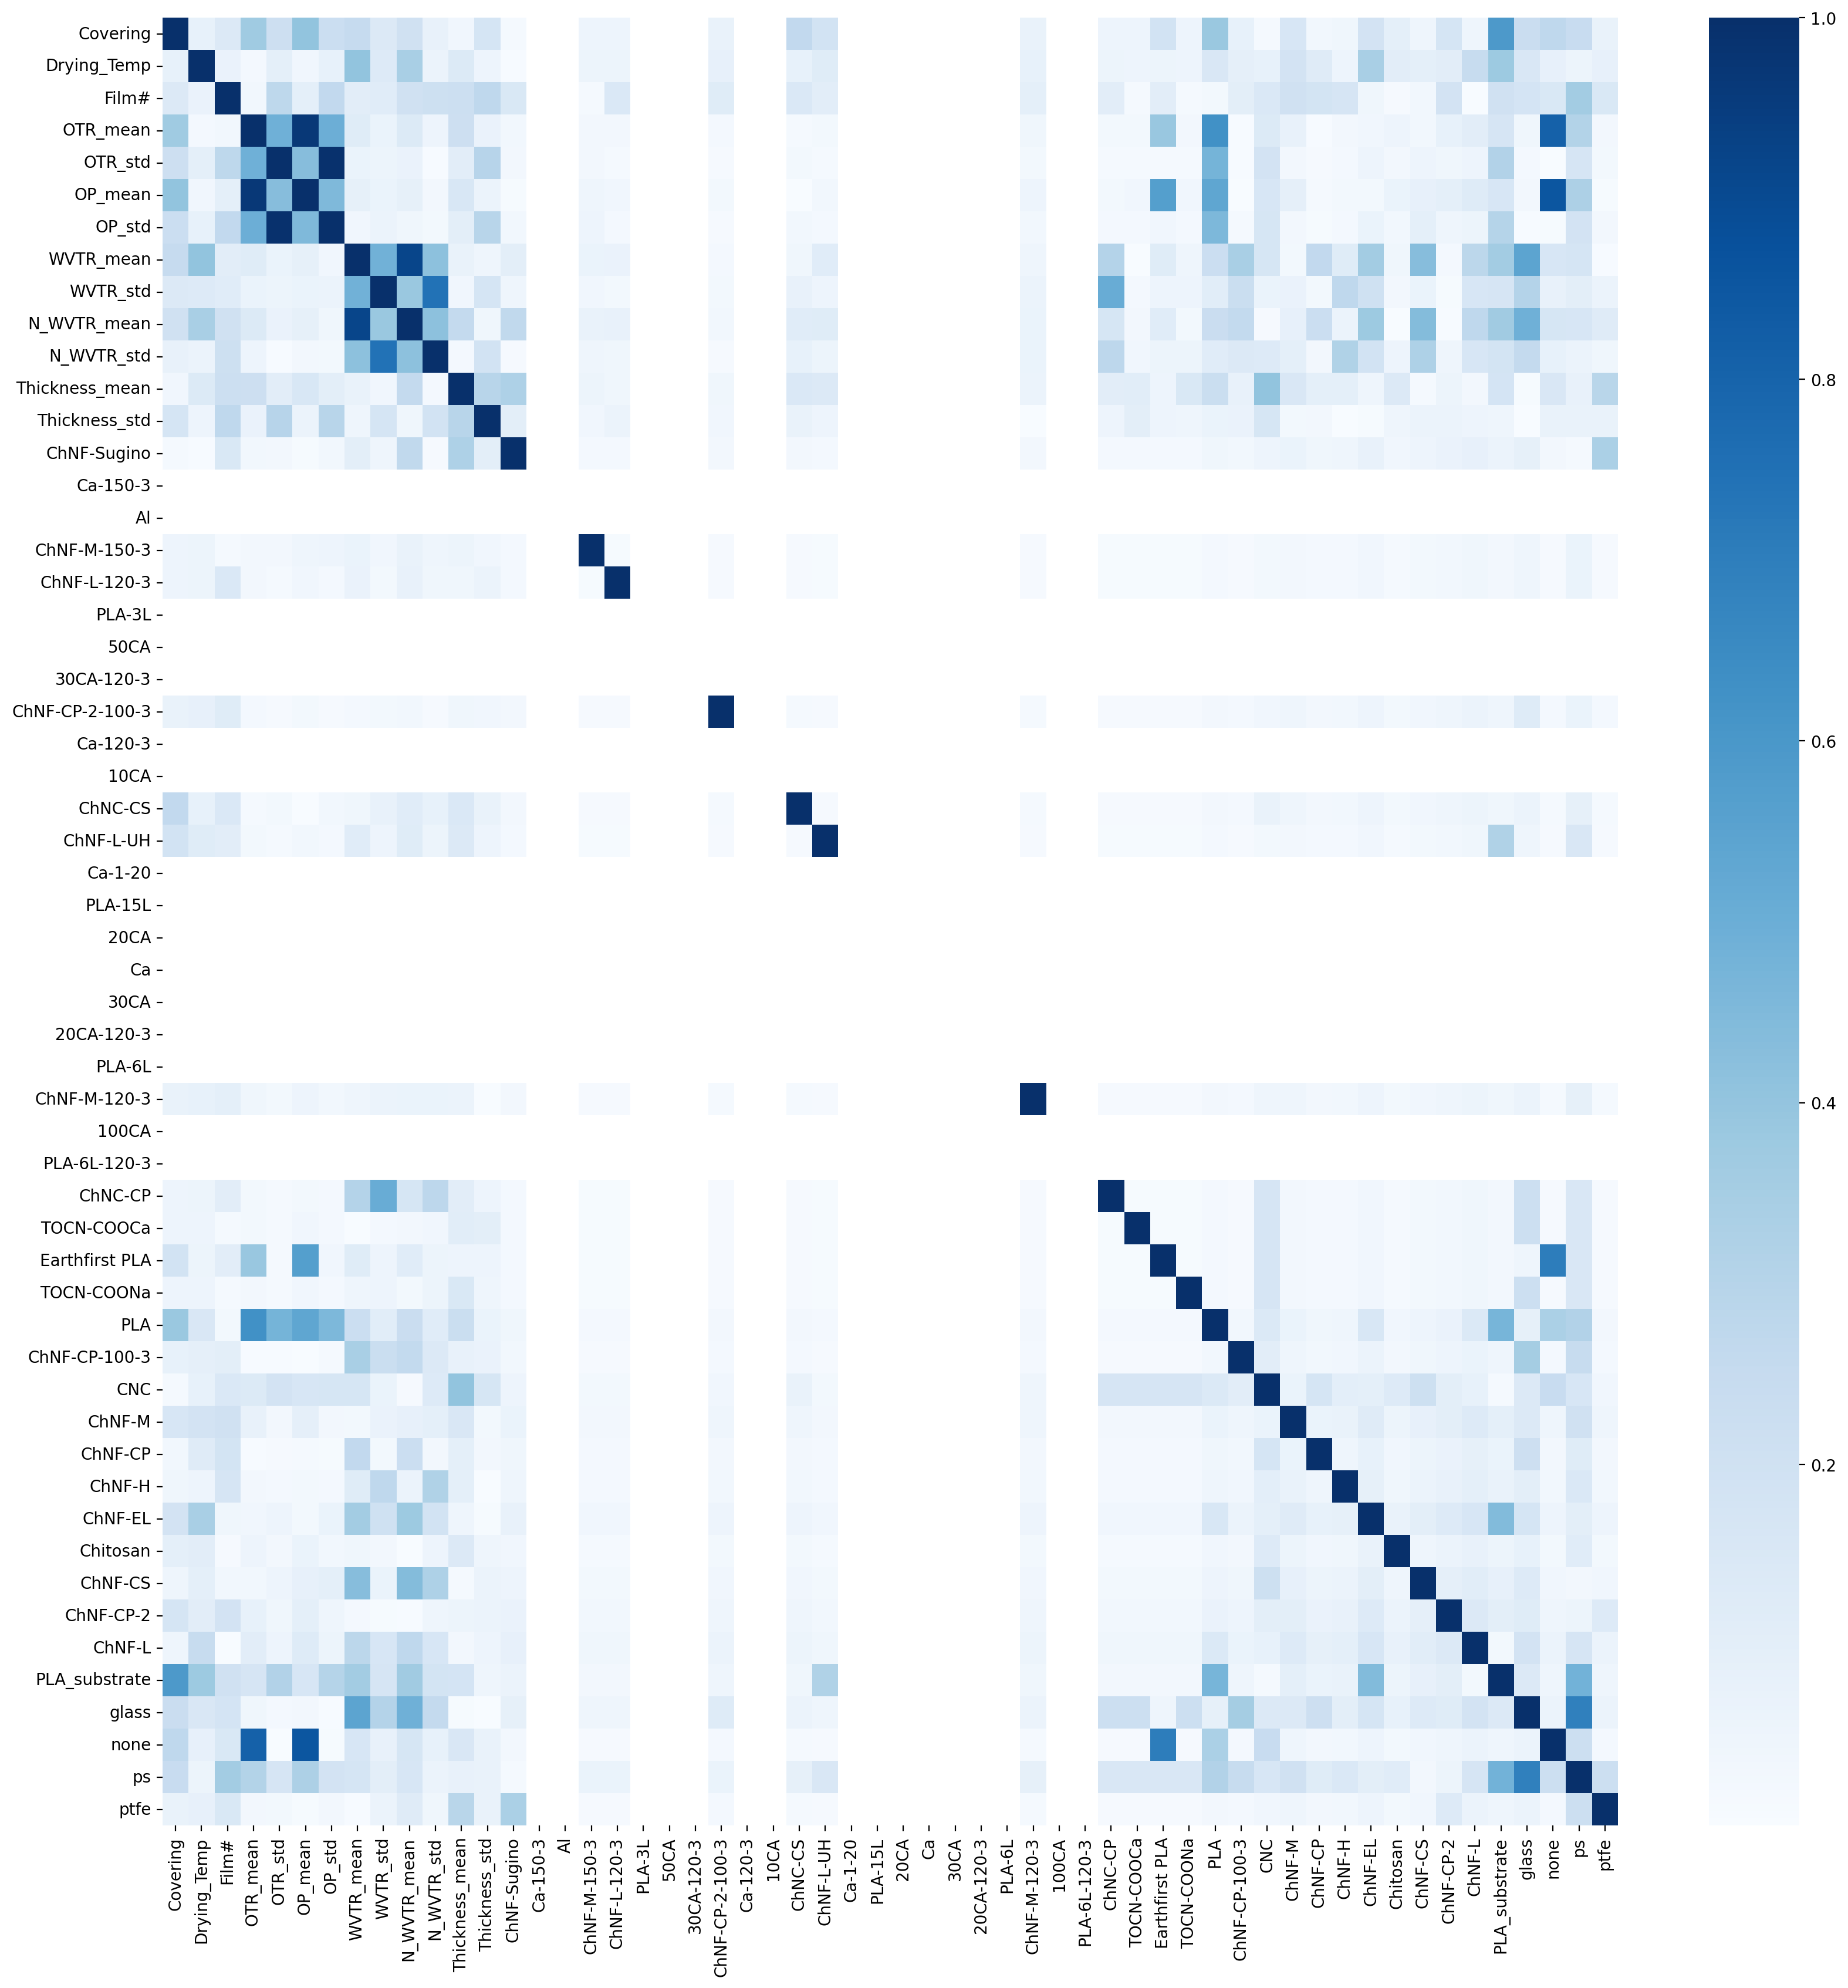

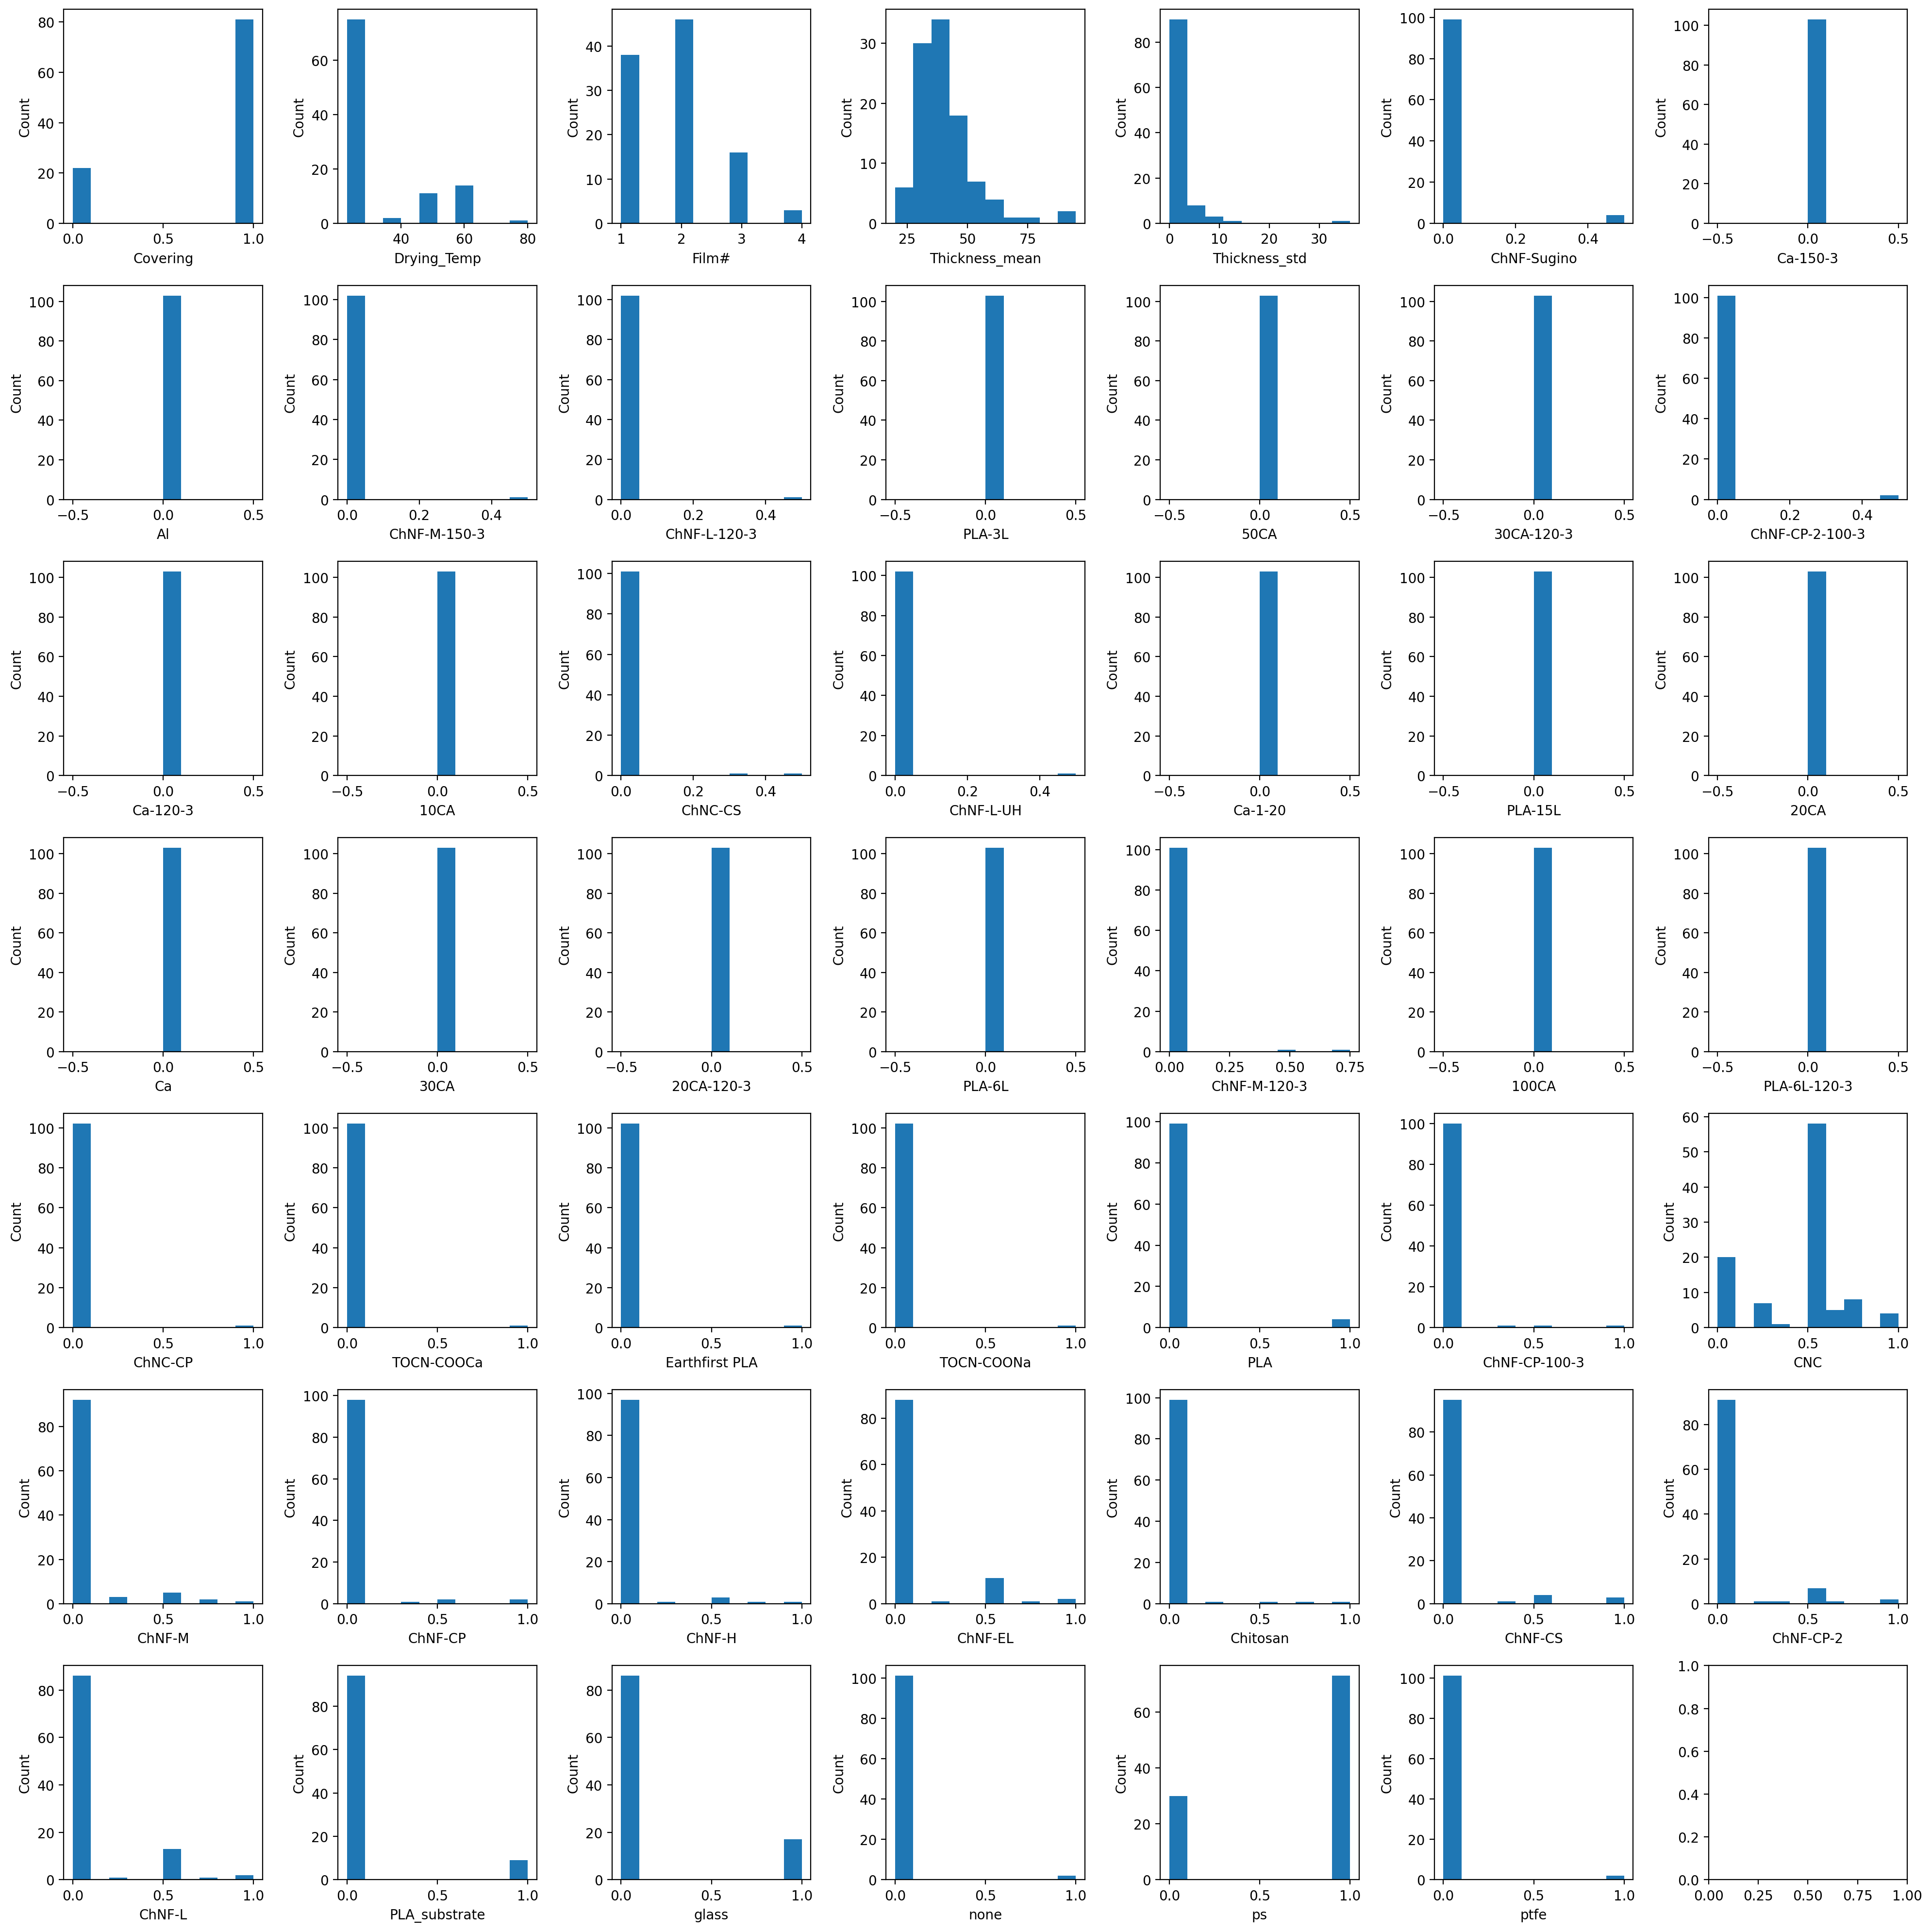

In [5]:
corr = df.corr().abs()
fig, ax = plt.subplots(figsize=(20,20),dpi=200)
sns.heatmap(corr,ax = ax, cmap='Blues', annot=False,)
fig.savefig('./figures/Correlation_Matrix_RH50.png')

Targets = ['OTR_mean','OTR_std','OP_mean','OP_std','WVTR_mean','WVTR_std','N_WVTR_mean','N_WVTR_std']
Features = [i for i in df.columns if i not in Targets]
n_plots = len(Features)
n_axis = int(np.ceil(np.sqrt(n_plots)))
fig, ax = plt.subplots(n_axis,n_axis,figsize=(20,20),dpi=200)
for i in range(n_axis):
    for j in range(n_axis):
        if i*n_axis+j < n_plots:
            ax[i,j].hist(df[Features[i*n_axis+j]])
            ax[i,j].set_xlabel(Features[i*n_axis+j])
            ax[i,j].set_ylabel('Count')
plt.tight_layout()

fig.savefig('./figures/Feature_Distributions_RH50.png')

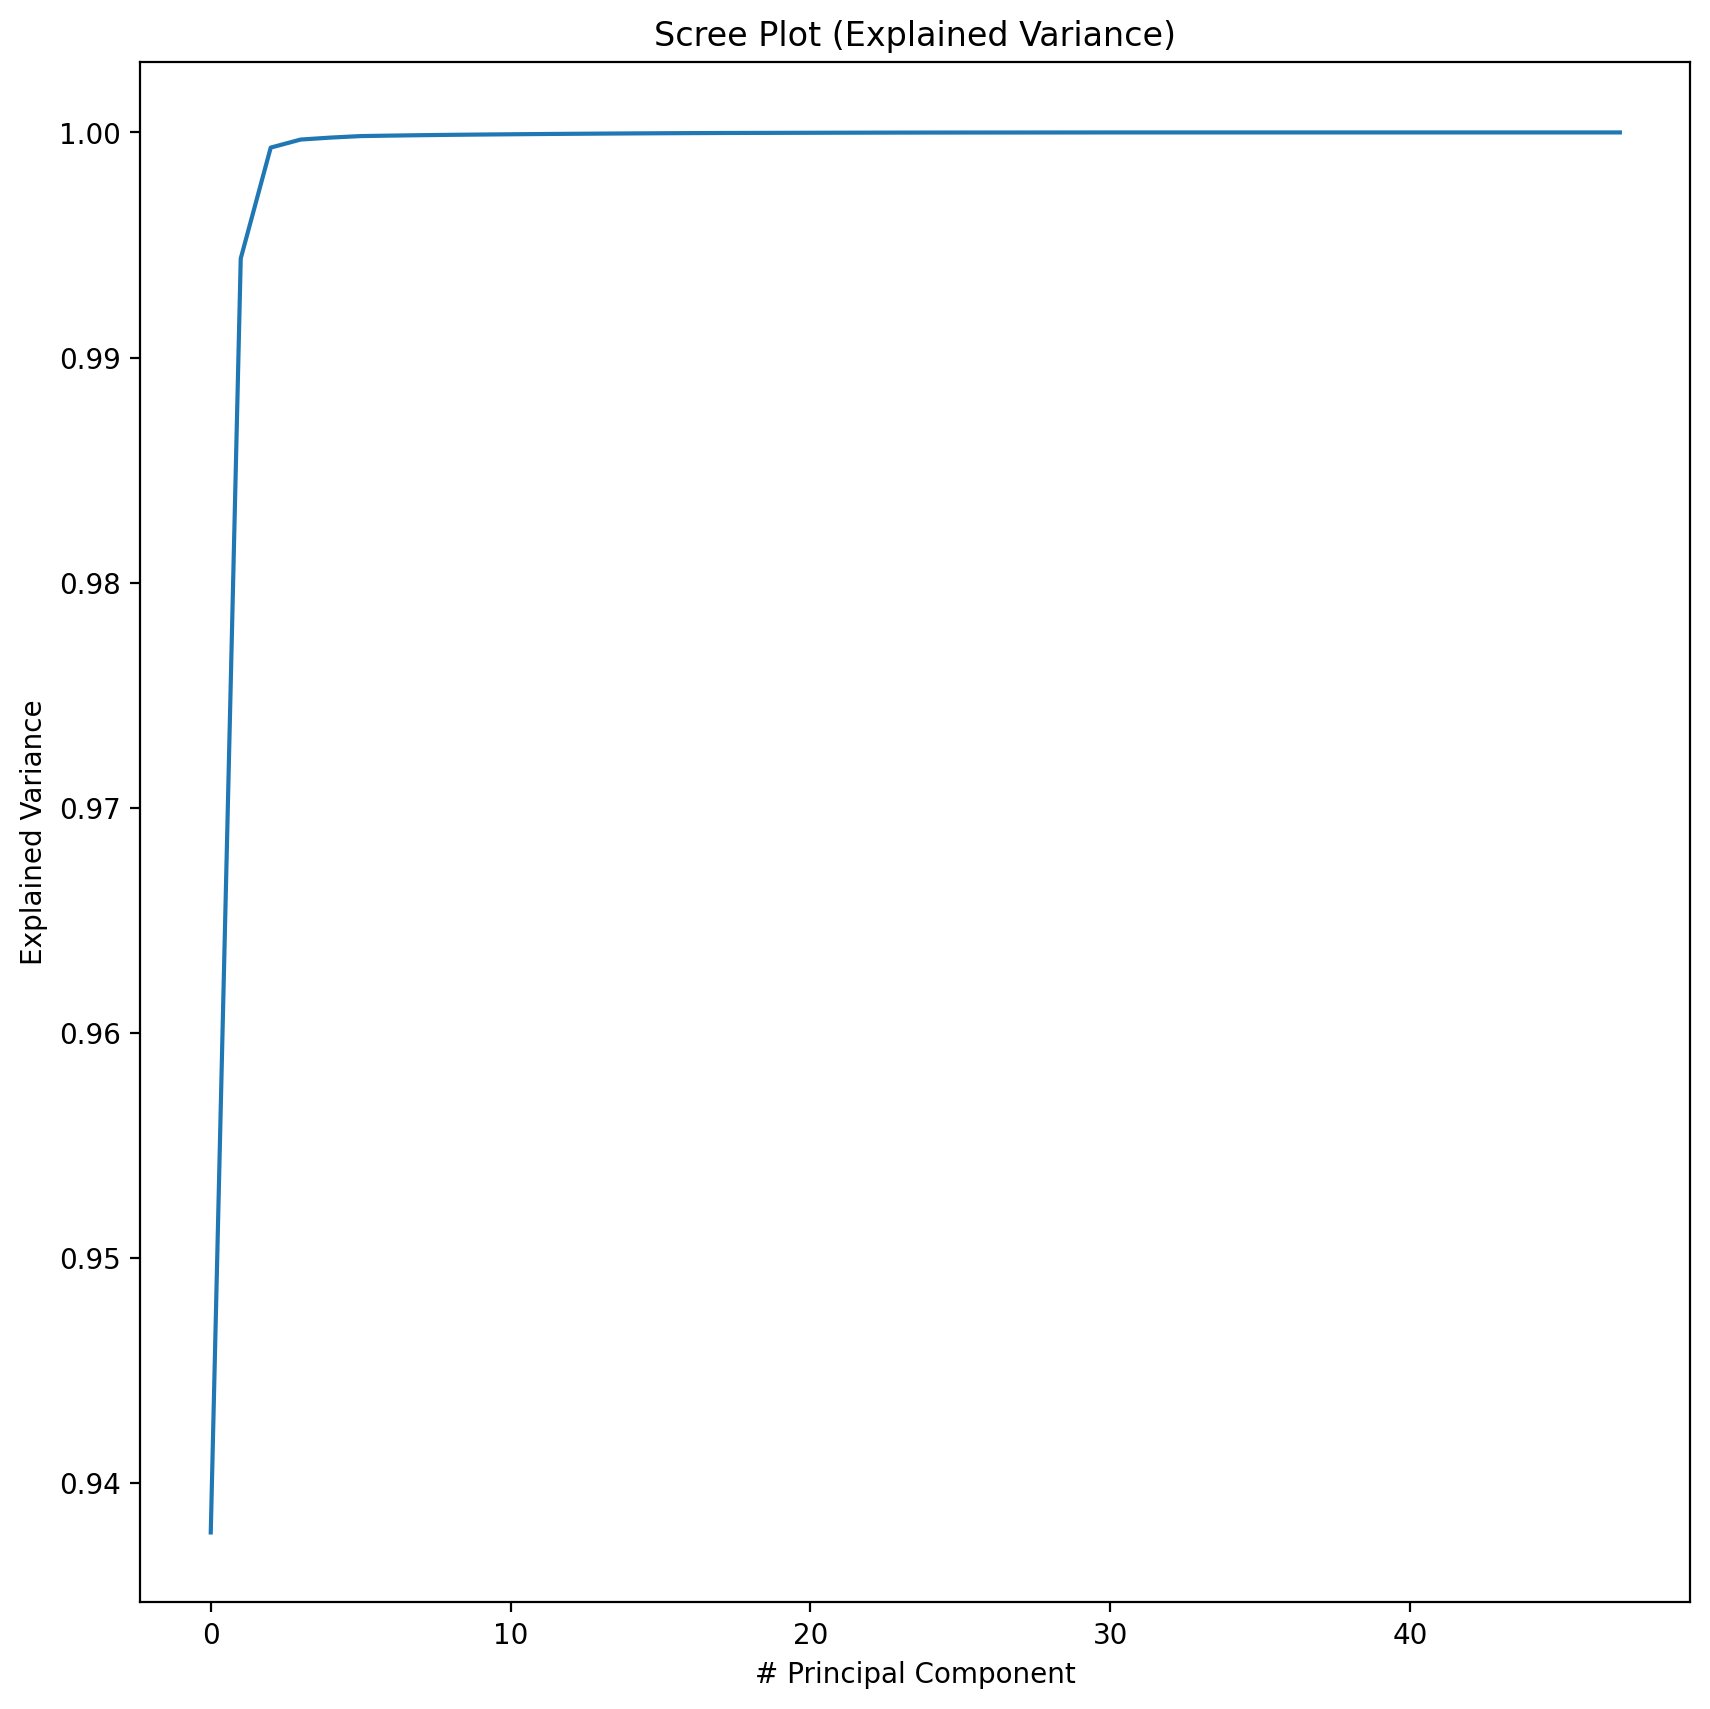

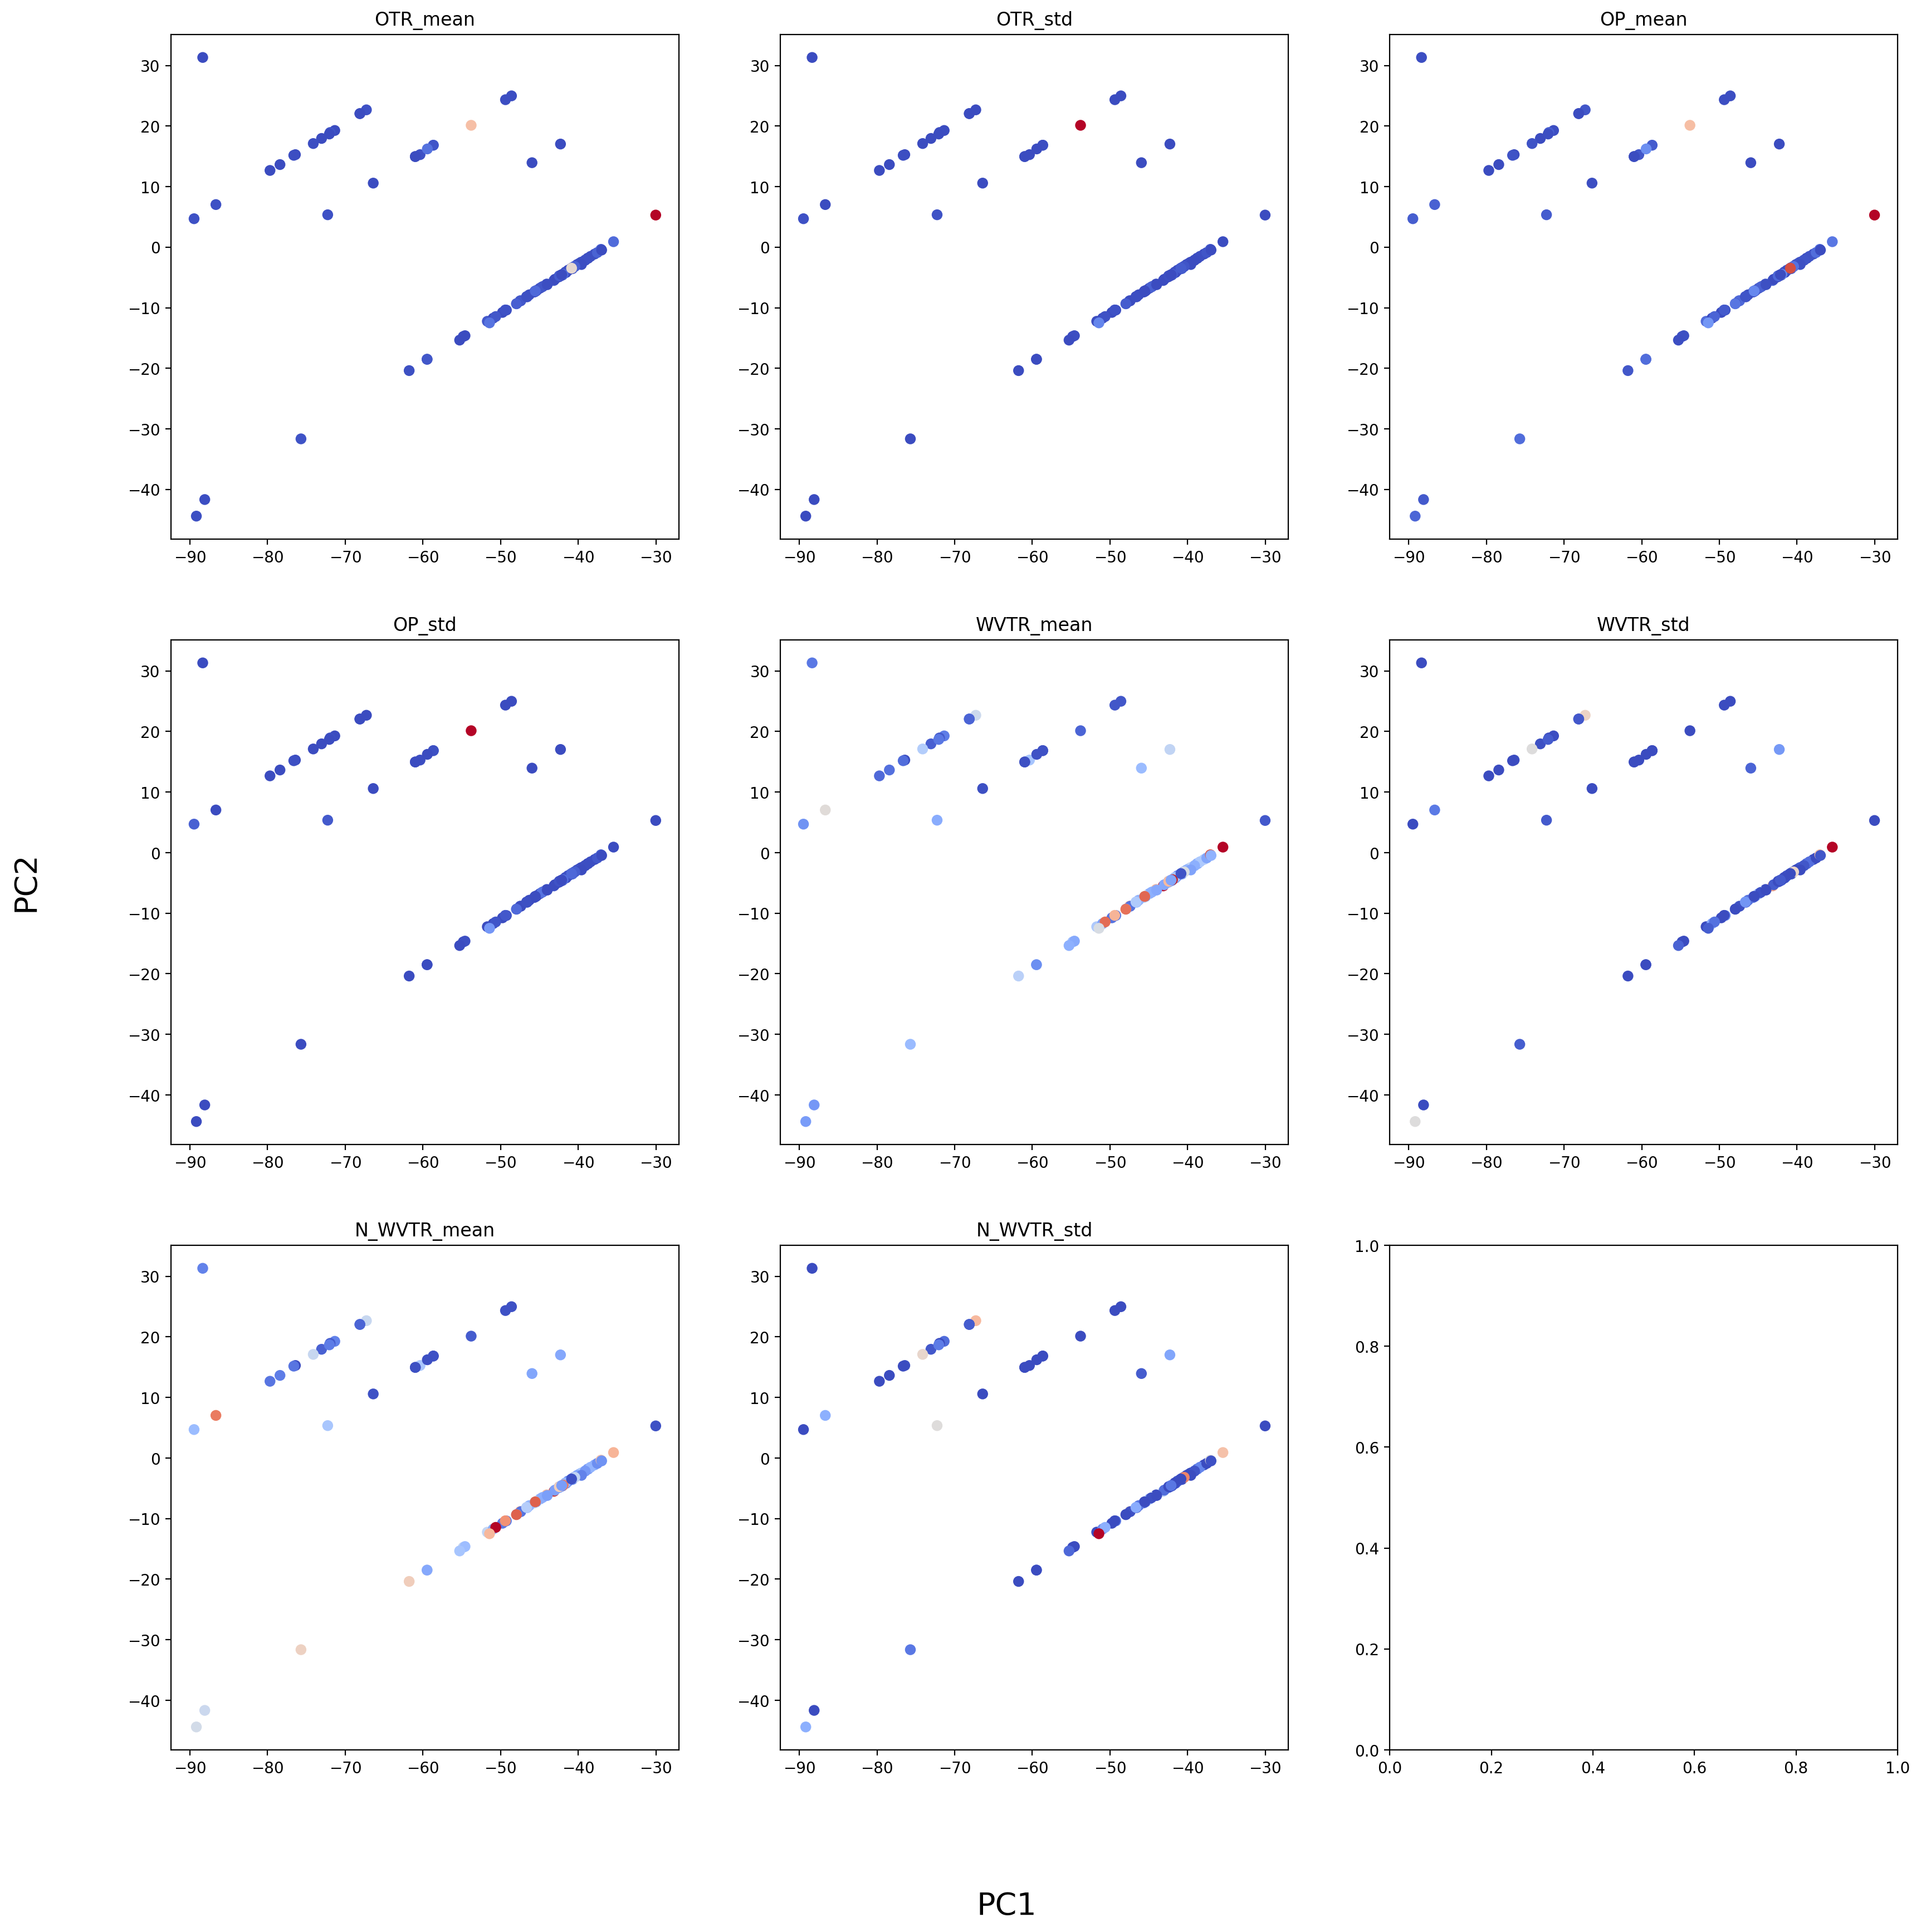

In [6]:
numeric_features = df[Features].to_numpy()
numeric_targets = df[Targets].to_numpy()

covariance_matrix = np.dot(numeric_features.T, numeric_features)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
explained_variance = np.cumsum(eigenvalues/np.sum(eigenvalues))
fig, ax = plt.subplots(figsize=(10,10),dpi=200)
ax.plot(explained_variance)
ax.set_title('Scree Plot (Explained Variance)')
ax.set_xlabel('# Principal Component')
ax.set_ylabel('Explained Variance')
fig.savefig('./figures/Scree_Plot_RH50.png')

# PCA projection
PCA_comps = np.dot(numeric_features, eigenvectors[:,:2])

n_targets = len(Targets)
n_axis = int(np.ceil(np.sqrt(n_targets)))
fig, ax = plt.subplots(n_axis,n_axis,figsize=(20,20),dpi=200)
for i in range(n_axis):
    for j in range(n_axis):
        if i*n_axis+j < n_targets:
            ax[i,j].scatter(PCA_comps[:,0], PCA_comps[:,1], c=numeric_targets[:,i*n_axis+j], cmap='coolwarm')
            ax[i,j].set_title(Targets[i*n_axis+j])

fig.text(0.5, 0.04, 'PC1', ha='center', va='center', fontdict={'fontsize': 20})
fig.text(0.06, 0.5, 'PC2', ha='center', va='center', rotation='vertical',fontdict={'fontsize': 20})

fig.savefig('./figures/PCA_Projection_RH50.png')

### Linear Regression

In [7]:
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Using all features
all_features_mses = []
for col in df.columns:
    data = df.copy()
    y = data[f'{col}'].to_numpy()
    data = data.drop(columns=[f'{col}'])
    assert col not in data.columns.to_list()
    X = data.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    model = LinearRegression().fit(X_train, y_train)
    #print("R^2: ", model.score(X, y))
    y_pred = model.predict(np.array(X_test))
    mse = mean_squared_error(y_test, y_pred)
    all_features_mses.append(mse)

# Using pairs 
pairs_mses = []
pairs = itertools.permutations(df.columns.to_list(), 2)
for pair in pairs:
    x_col = pair[0]
    y_col = pair[1]
    data = df.copy()
    data = data[[f'{x_col}', f'{y_col}']]
    y = data[f'{y_col}'].to_numpy()
    data = data.drop(columns=[f'{y_col}'])
    assert y_col not in data.columns.to_list()
    X = data[f'{x_col}'].to_numpy().reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    model = LinearRegression().fit(X_train, y_train)
    #print("R^2: ", model.score(X, y))
    y_pred = model.predict(np.array(X_test))
    mse = mean_squared_error(y_test, y_pred)
    pairs_mses.append(mse)

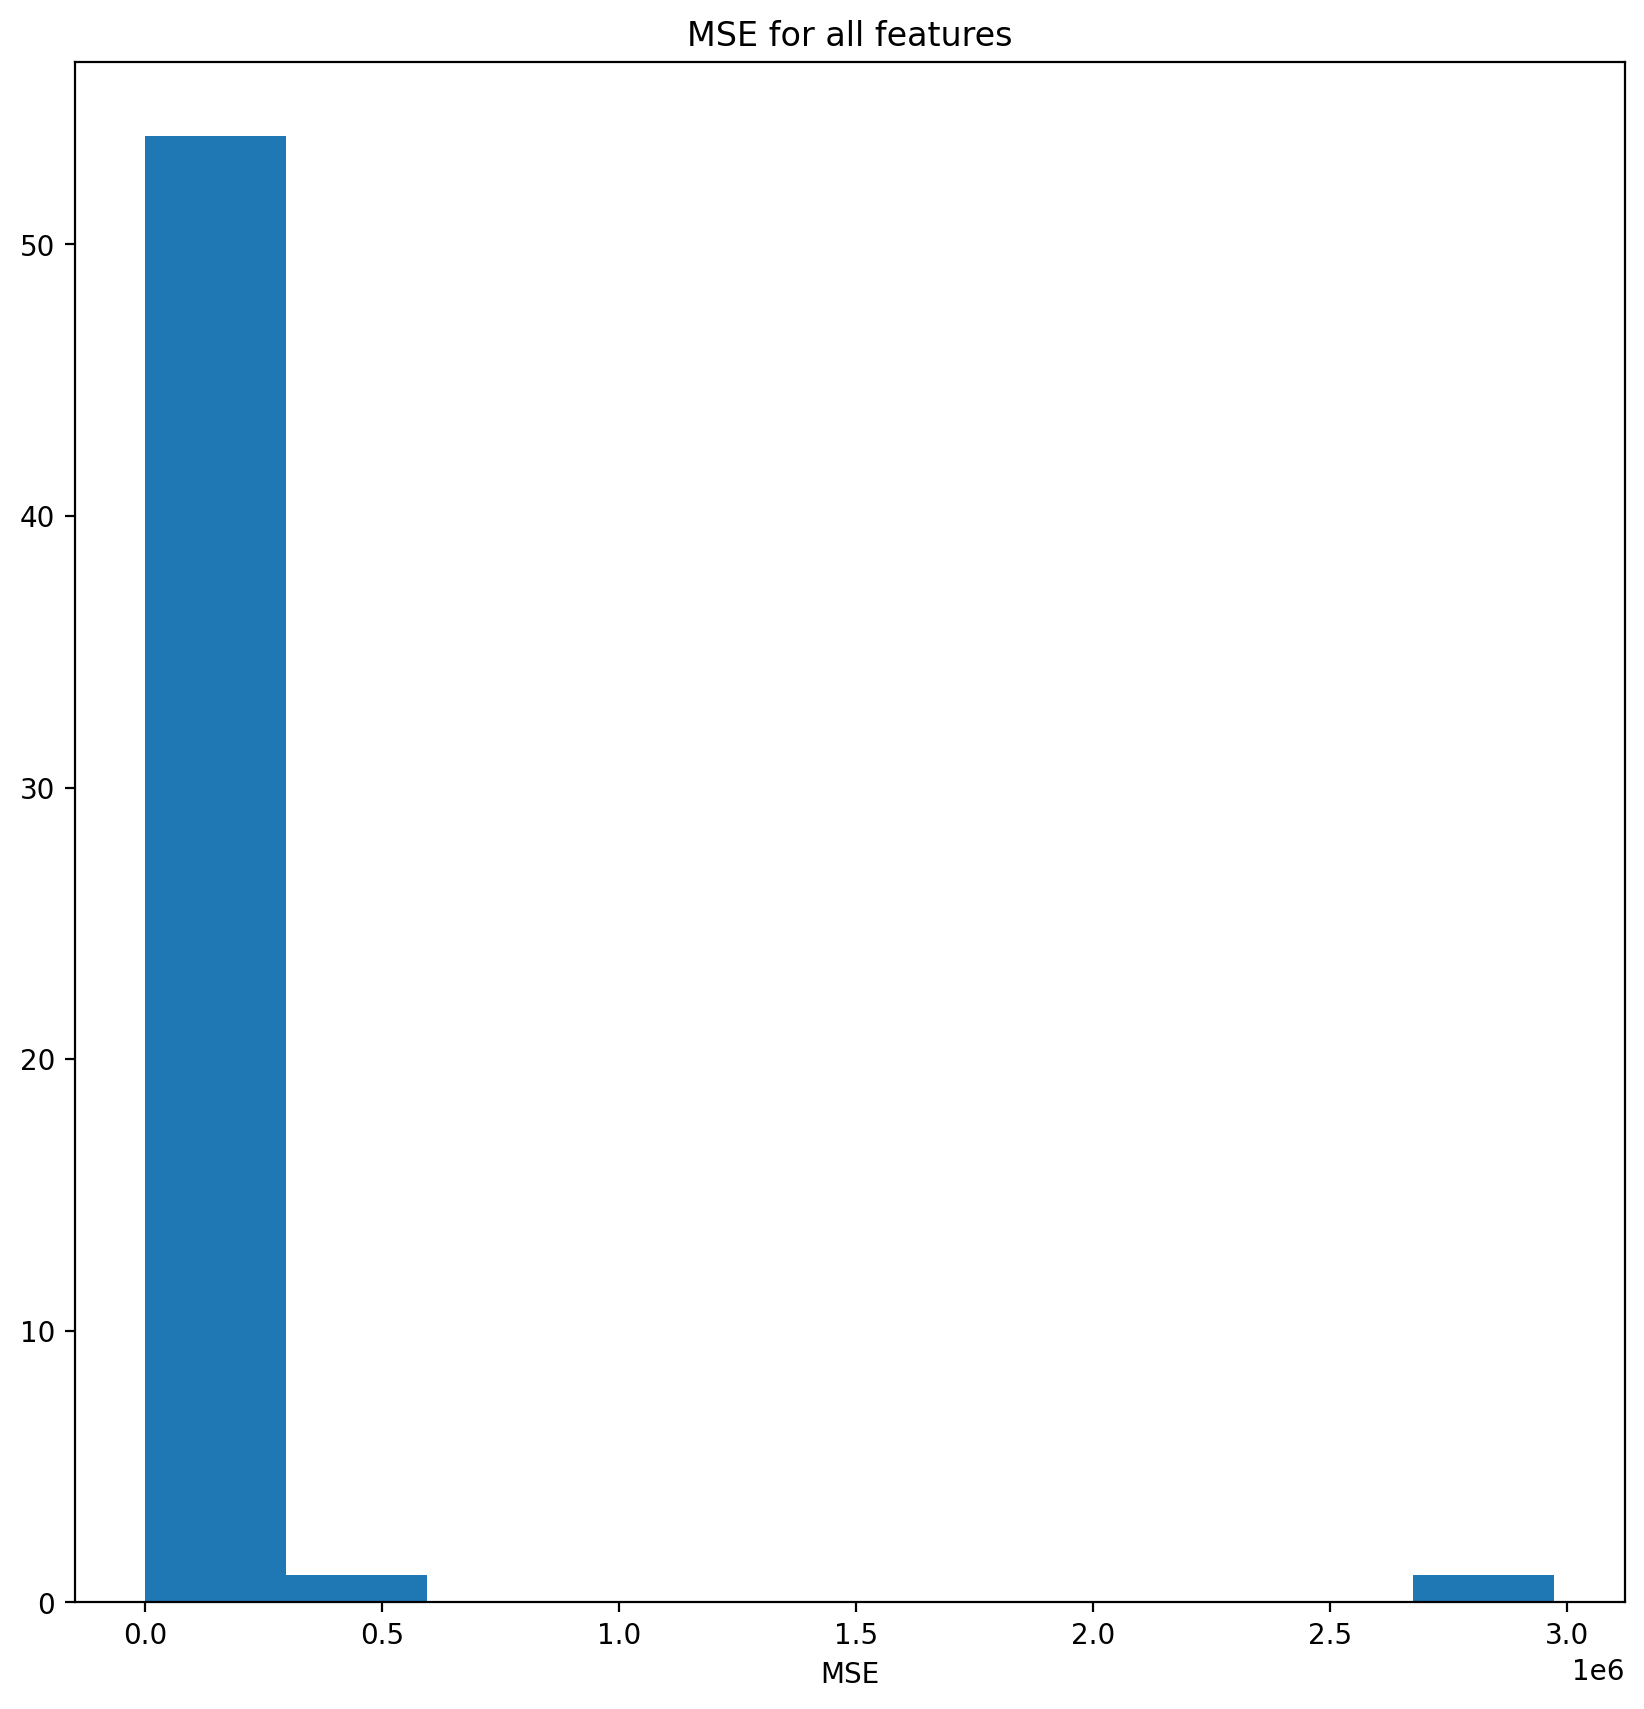

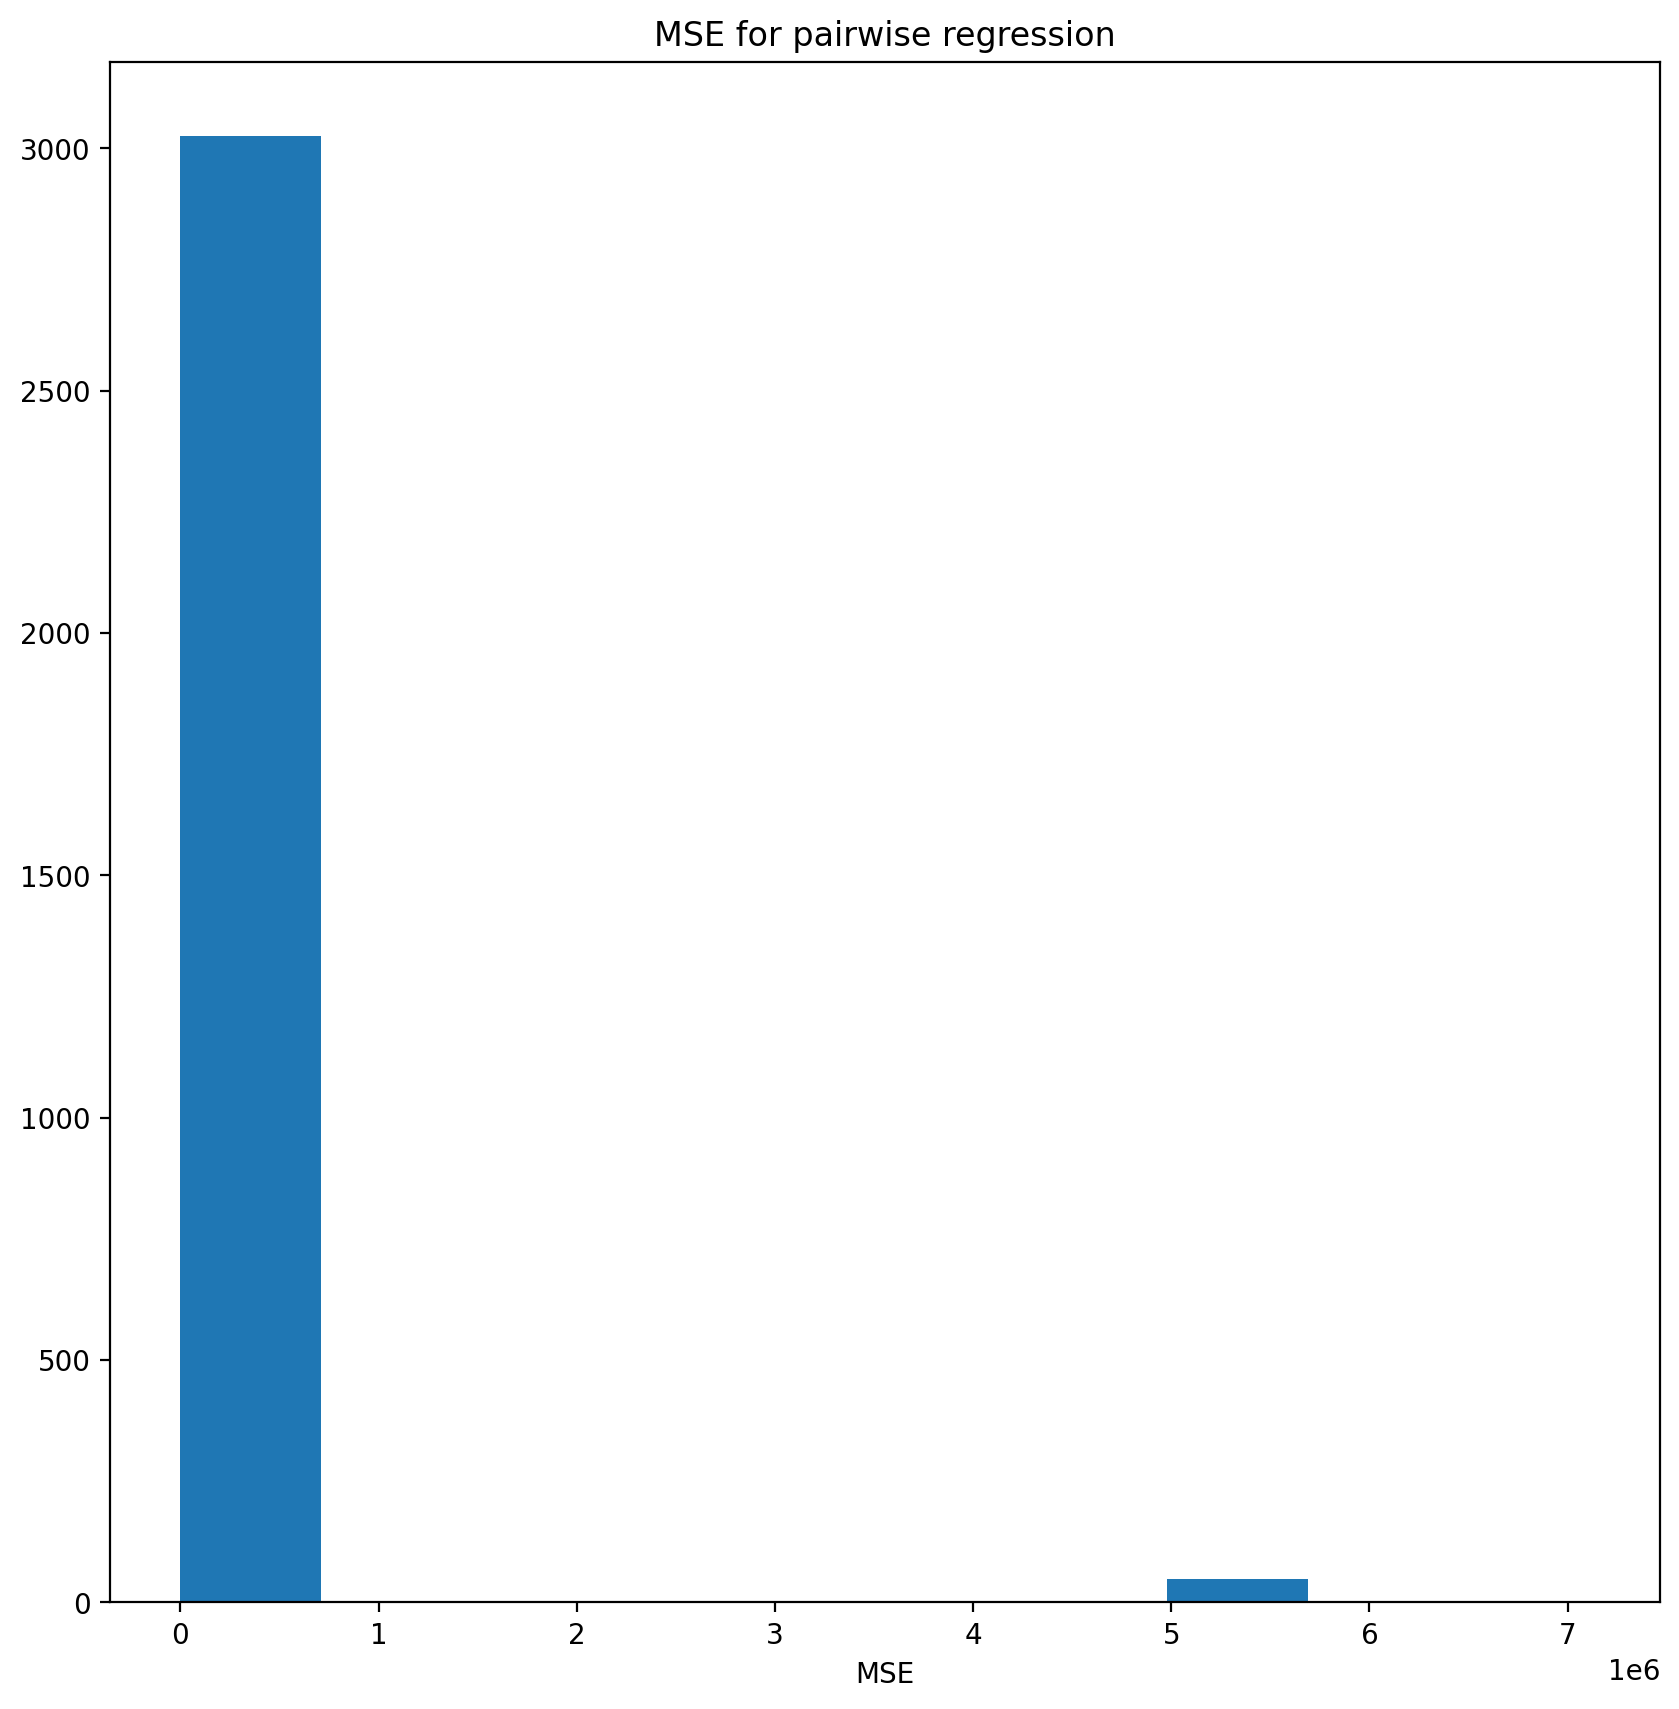

In [8]:
fig, ax = plt.subplots(figsize=(10,10),dpi=200)
ax.hist(all_features_mses, 10)
ax.set_title('MSE for all features')
ax.set_xlabel('MSE')
fig.savefig('./figures/MSE_All_Features_RH50.png')

fig, ax = plt.subplots(figsize=(10,10),dpi=200)
ax.hist(pairs_mses, 10)
ax.set_title('MSE for pairwise regression')
ax.set_xlabel('MSE')
fig.savefig('./figures/MSE_Pairs_RH50.png')

## A Tale of Two Problems, Part 2: Benchmarking Synthetic Data
### ChBE 6746/4746 Spring 2023 Group 3

In this notebook, our group compared several different solvers from the Gradient-Free-Solvers package by SimonBlanke: https://github.com/SimonBlanke/Gradient-Free-Optimizers

TA Suryateja Ravutla graciously provided test problems in files `bcp8.npy` as well as starting code to load problems and visualize 2D problems.

### Load Test Problems

In [9]:
# load benchmarks problems

import numpy as np

bcp = np.load('./load_data/bcp8.npy', allow_pickle=True).item()
eqc = np.load('./load_data/eqcS.npy', allow_pickle=True).item()

class prb:   # this will be your black box function
    def __init__(self, prob, noisy_level):
        # function for generating data
        self.func=prob['func']
        # number of constraints
        self.n_con=prob['n_con']
        # noise level
        self.nl=noisy_level
        # constraints
        self.con=[]
        for i in range(self.n_con):
            self.con.append(prob['con'+str(i+1)])
    def datcol(self,x):
        try:
            # eval takes string type input and evaluates python code. Input can be
            # a mathematical function or a python function which will be called.
            y = eval(self.func)
        except:
            x = np.array([x])
            y = eval(self.func)
        return float(y)
    def constraint(self, x):
        # Appears to evaluate if the constraints are satisfied
        # returns 1 if all constraints are satisfied, else -1
        try:     
            m,n=np.shape(x)
        except:
            x = np.array([x])
            m,n=np.shape(x)
        y=np.empty((self.n_con))
        for i in range(self.n_con):
            y[i]=eval(self.con[i])     
        if y.all() == 1.:
            label = 1.
        else:
            label = -1.
        return label

class benchmark:
    def __init__(self, func, noisy_level):
        self.func = str(func)
        self.nl = noisy_level
    def datcol(self, x):
        try:
            y = eval(self.func)
        except:
            x = np.array([x])
            y = eval(self.func)
        return float(y)

### Example Visualization of 2D Problem `BeckerLago`

BeckerLago function:
(-5 + np.sqrt(x[:,0]**2))*(-5 + np.sqrt(x[:,0]**2)) + (-5 + np.sqrt(x[:,1]**2))*(-5 + np.sqrt(x[:,1]**2))
lower bounds:
[4.5 4.5]
upper bounds:
[5.5 5.5]



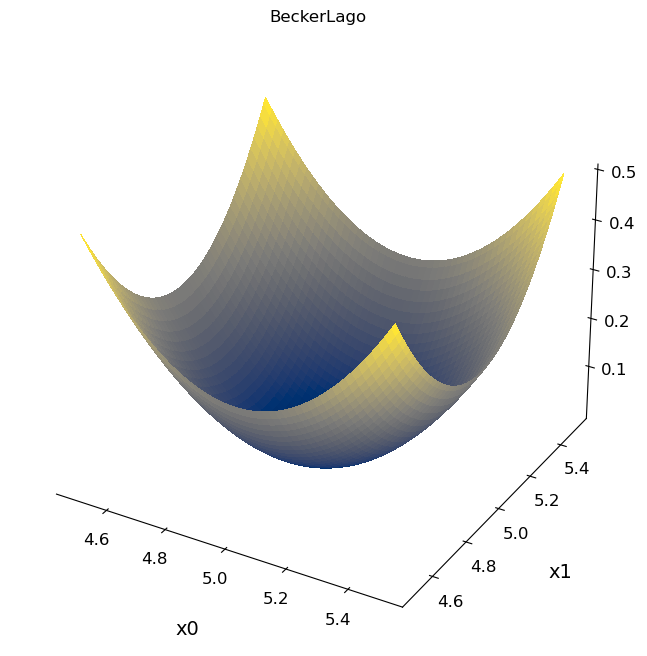

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# source contains problems as numpy array - really a dictionary
# params of bcp dictionary
# yopt - optimal value
# xopt - optimal solution
# xlb - lower bound
# xub - upper bound
# n - dimensionality
# func - function to be evaluated - exists as string version of argument where x[:,0] is first variable and x[:,1] is second variable

# names = list(bcp.keys())
# for i in names:
for i in ['BeckerLago']:
    # n defines dimensionality - ensures we are only plotting 2D problems
    if bcp[i]['n'] == 2:
        prob = bcp[i]
        xlb = prob['xlb']
        xub = prob['xub']
        # pass problem to benchmark class to enable evaluation
        prbf = benchmark(prob['func'],0)
        bounds = np.array([xlb, xub])
        x = np.linspace(bounds[0,0],bounds[1,0],100)
        y = np.linspace(bounds[0,1],bounds[1,1],100)

        X,Y = np.meshgrid(x,y)
        f = prob['func'].replace("x[:,0]", "X").replace("x[:,1]", "Y")
        Z = eval(f)

        fig = plt.figure(figsize=(8,8), dpi=100)
        ax = fig.add_subplot(111, projection='3d')
        # plt.tight_layout(rect=(4, 1, 1, 1))

        print(
            f'{i} function:\n'
            f'{prob["func"]}\n'
            f'lower bounds:\n'
            f'{xlb}\n'
            f'upper bounds:\n'
            f'{xub}\n'
            # f'number of constraints:\n'
            # f'{prob["n_con"]}'
        )

        # Plot a 3D surface
        ax.plot_surface(X, Y, Z, cmap="cividis", antialiased=False)
        ax.set_xlabel('x0',labelpad= 20, fontsize=14)
        ax.set_ylabel('x1',labelpad= 20, fontsize=14)
        ax.set_zlabel('f(x0,x1)',labelpad= 20, fontsize=14)
        ax.set_title(i)
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.zaxis.set_tick_params(labelsize=12)
        ax.grid(False)
        plt.show()

In [3]:
n = 0
for key, value in eqc.items():
    if 'n_con' in value.keys() and value['n_con'] > 0:
        n += 1
print(n)
print(len(eqc.keys()))

347
369


### Identify Valid Problems

In [2]:
import numbers

def get_valid_problems(source, names):
    """ 
    Some provided solutions may be invalid. This function returns valid/invalid solutions
    """

    valid_problems = []
    invalid_problems = []
    for name in names: 
        dims = source[f'{name}']['n']
        try:
            assert len(source[f'{name}']['xub']) == dims and len(source[f'{name}']['xlb']) == dims
            assert len(source[f'{name}']['xopt']) == dims and isinstance(source[f'{name}']['yopt'], numbers.Number)
            assert ('n_con' not in source[f'{name}'].keys()) or ('n_con' in source[f'{name}'].keys() and source[f'{name}']['n_con'] == 0)
            valid_problems.append(name)
        except:
            invalid_problems.append(name)
            continue

    # print(f"There are {len(valid_problems)} valid problems and {len(invalid_problems)} invalid problems")
    
    return valid_problems, invalid_problems

names_bcp = list(bcp.keys())
names_eqc = list(eqc.keys())
bcp_valid_probs, bcp_invalid_probs = get_valid_problems(bcp, names_bcp)
eqc_valid_probs, eqc_invalid_probs = get_valid_problems(eqc, names_eqc)

all_valid_probs = bcp_valid_probs + eqc_valid_probs
bcp_valid_probs.sort()
eqc_valid_probs.sort()
all_valid_probs.sort()
print(f'bcp valid problems: {len(bcp_valid_probs)}')
print(f'{bcp_valid_probs}\n')
print(f'eqc valid problems: {len(eqc_valid_probs)}')
print(f'{eqc_valid_probs}\n')
print(f'total valid problems: {len(all_valid_probs)}')
print(all_valid_probs)

bcp_valid_dims = [bcp[i]['n'] for i in bcp_valid_probs]
bcp_valid_functions = [
    bcp[i]['func'].replace(':,', '').replace('[', '').replace(']', '')
    for i in bcp_valid_probs
]

df_bcp = pd.DataFrame({
    'Name': bcp_valid_probs,
    'Dimensions': bcp_valid_dims,
    'Function': bcp_valid_functions
})
df_bcp.to_csv('bcp_valid_probs.csv')


bcp valid problems: 263
['3pk', 'AluffiPentini', 'BeckerLago', 'Camel3', 'Camel6', 'DekkersAarts', 'Expo', 'GoldPrice', 'Hartman3', 'Hosaki', 'MeyerRoth', 'ModRosenbrock', 'MultiGauss', 'Neumaier2', 'Neumaier3', 'Paviani', 'PowellQ', 'PriceTransistor', 'Shekel10', 'Shekel7', 'Shekelfox10', 'Shekelfox5', 'Wood', 'aircrftb', 'arglinb', 'arglinc', 'biggs3', 'biggs5', 'biggs6', 'biggsb1', 'box3', 'bqp1var', 'brownal', 'brownbs', 'brownden', 'camel1', 'chnrosnb', 'cliff', 'concha1', 'concha10', 'concha11', 'concha12', 'concha2', 'concha3', 'concha4', 'concha5', 'concha5a', 'concha8', 'concha9', 'cube', 'denschna', 'denschnb', 'denschnc', 'denschnd', 'denschne', 'denschnf', 'dixon3dq', 'draper1', 'draperg', 'draperj', 'drapero', 'eigena', 'eigenals', 'eigenb', 'eigenbls', 'engval2', 'errinros', 'ex005', 'ex4_1_1', 'ex4_1_2', 'ex4_1_3', 'ex4_1_4', 'ex4_1_5', 'ex4_1_6', 'ex4_1_7', 'ex8_1_3', 'ex8_1_4', 'ex8_1_5', 'ex8_1_6', 'explin', 'explin2', 'expquad', 'extrosnb', 'fermat2_eps', 'fermat2_va

NameError: name 'pd' is not defined

### Evaluate Dimensionality

Here we evaluate overall dimensionality based on number of problems and percentage of problems:

In [5]:
def get_dimensions(list_problems:list):
    dict_dim = {}
    for problem in list_problems:
        dim = bcp[problem]['n']
        if dim not in dict_dim.keys():
            dict_dim[dim] = 1
        else:
            dict_dim[dim] += 1 
    dict_dim = dict(sorted(dict_dim.items()))
    return dict_dim

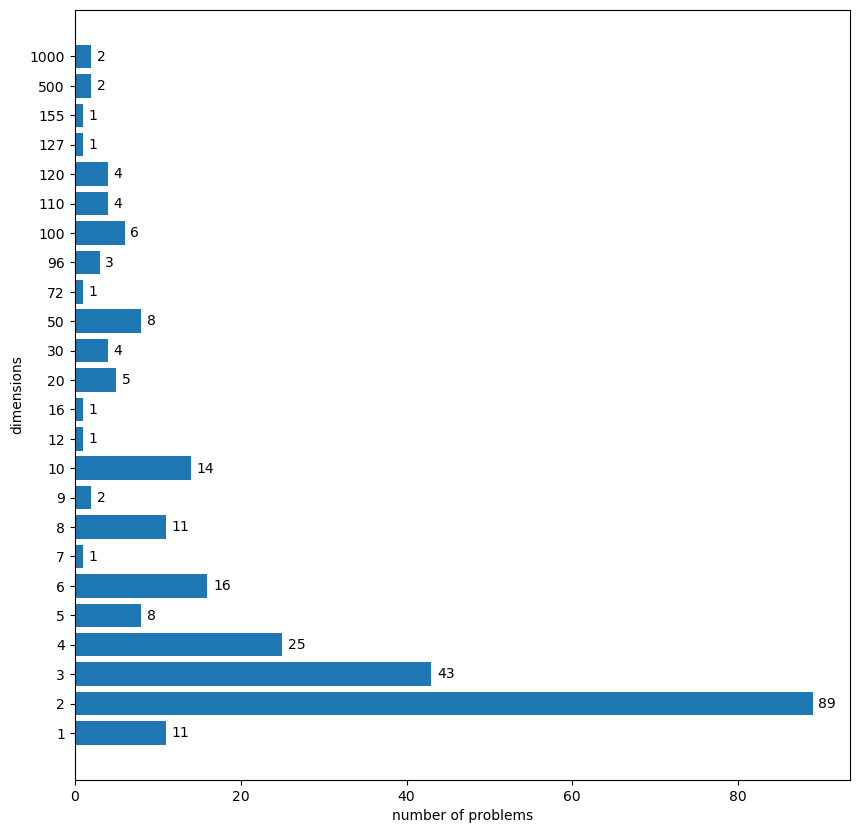

In [6]:
dict_dim = get_dimensions(bcp_valid_probs)
dims = list(dict_dim.keys())
dims = [str(i) for i in dims]
n_probs = list(dict_dim.values())

fig, ax = plt.subplots(figsize=(10,10), dpi=100)
bars = ax.barh(dims, n_probs)
ax.set_xlabel('number of problems')
ax.set_ylabel('dimensions')
ax.bar_label(bars, padding=4);

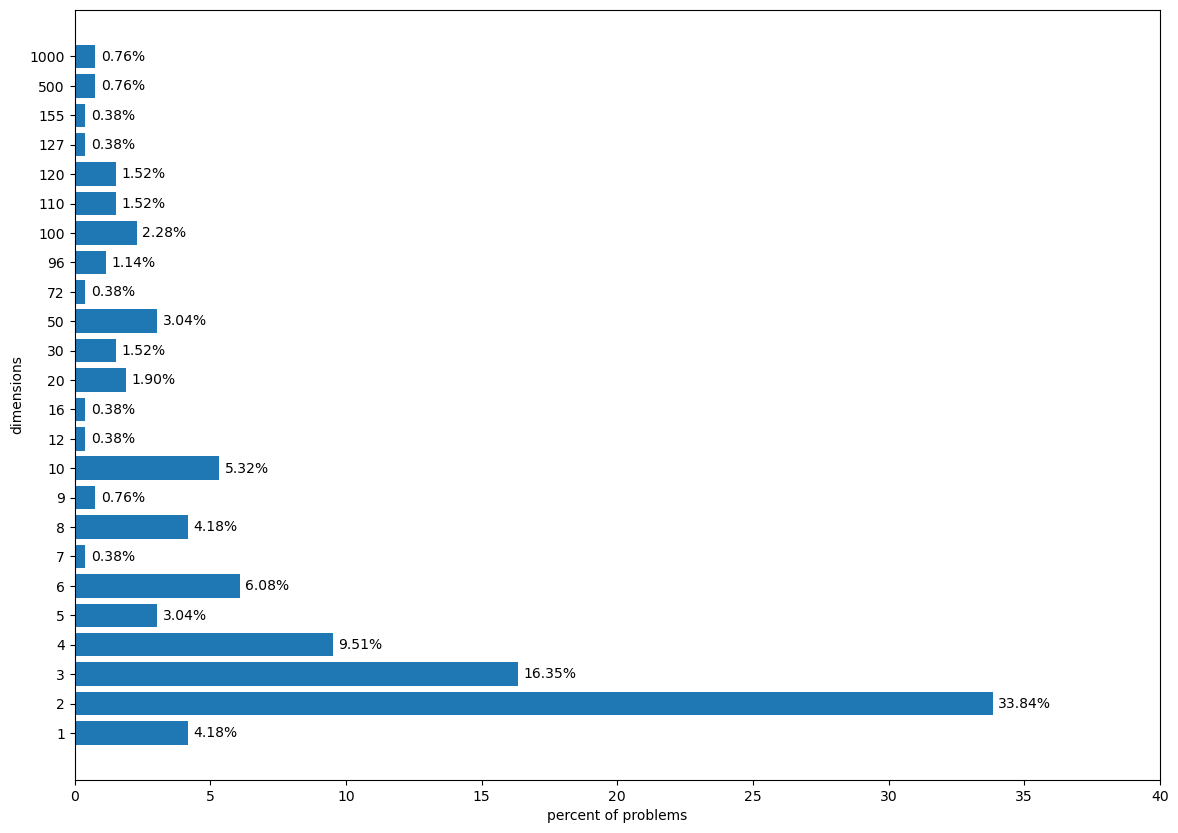

In [7]:
percent_probs = []
sum_probs = len(bcp_valid_probs)
for i in n_probs:
    percent_probs.append(100*i/sum_probs)

fig, ax = plt.subplots(figsize=(14,10), dpi=100)
bars = ax.barh(dims, percent_probs)
ax.set_xlabel('percent of problems')
ax.set_ylabel('dimensions')
ax.bar_label(bars, fmt='%.2f%%', padding=4)
ax.set_xlim(right=40);

### Evaluate Convexity

We tried to evaluate the convexity of each problem by calculating the eigenvalues from the Hessian matrix. However, we ran into issues when solutions for the partial derivatives could not be found within the given bounds for certain problems, even for 2d problems for which the convexity could be deduced visually from its plot, such as `AluffiPentini`.

Code was adapted from the following websites:  
https://towardsdatascience.com/hessian-matrix-and-optimization-problems-in-python-3-8-f7cd2a615371  
https://stackoverflow.com/questions/9492944/sympy-arbitrary-number-of-symbols 

In [10]:
# Functions for finding convexity

import numpy as np
from sympy import symbols, Eq, solve, diff, Matrix, pprint


def solve_for_zero(x, func, xlb, xub):
	"""
	Solve the null equation for f_partial and return the stationary coordinate.
	"""
	stationary_set = []
	for i in range(len(x)):
		eqn = Eq(func, 0)
		soln = solve(eqn, x[i])
		stationary_set.append(
			[v for v in soln if (v.is_real and v > xlb and v < xub)]
		)
		# stationary_set.append(soln)

	return stationary_set


def get_stationary_point(stationary_sets, n):
	"""
	Evaluates set of solutions (list of lists) for stationary point and returns
	a single stationary point.
	"""
	stationary_point = []
	dict_soln_idx = {}
	for i in range(len(stationary_sets)):  # set
		valid = 0
		invalid = 0
		soln_set = stationary_sets[i]
		for j in range(n):  # soln within set
			soln = soln_set[j]
			soln_idx = 0
			if soln == []:
				invalid += 1
			else:
				valid += 1
				soln_idx = j
		if valid == n:
			stationary_point = soln_set
		elif valid == 1:
			dict_soln_idx[soln_idx] = i
	if stationary_point == []:  # at least one soln is invalid in all sets
		for j in range(n):
			if j in dict_soln_idx.keys():
				i = dict_soln_idx.get(j)
				stationary_point.append(stationary_sets[i][j][0])
			else:
				stationary_point.append([])
	return stationary_point

			
def get_convexity(f, n, xlb, xub):
	"""
	Returns convexity as string if a valid stationary point was found.
	Otherwise returns error message.
	"""
	x = [symbols('x%d' % i) for i in range(n)]
	bounds = [
		[i for i in xlb],
		[i for i in xub]
	]
	f = f.replace(':,', '').replace('[', '').replace(']', '')
	f = f.replace('np.sqrt', 'sqrt')
	print(f'x: {x}')
	print(f'f: {f}')
	print(f'bounds: {bounds}')
	
	# find first-order partial derivatives
	partials = []
	for i in range(n):
		partial_diff = diff(f, x[i])
		print(f'partial_{i}: {partial_diff}')
		partials.append(partial_diff)

	# find stationary point coordinates by solving each partial at 0
	stationary_sets = []
	for i in range(n):
		stationary_sets.append(
			solve_for_zero(x, partials[i], bounds[0][i], bounds[1][i])
			# solve_for_zero(x, partials[i])
		)
	print(f'solutions: {stationary_sets}')
	for i in range(n-1):
		set_i = stationary_sets[i]
		set_j = stationary_sets[i+1]
	stationary = get_stationary_point(stationary_sets, n)
	print(f'stationary point: {stationary}')
	for i in range(n):
		if stationary[i] == []:
			print('Error: Stationary point contains one or more null values. Cannot evaluate.')
			return

	# find second-order derivatives at stationary point
	hessian = []
	for i in range(n):
		row = []
		for j in range(n):
			partial_second = diff(partials[i], x[j])
			print(f'partial_second_{i}_{j}: {partial_second}')
			partial_sub = \
				partial_second.subs([(x[k], stationary[k]) for k in range(n)])
			row.append(partial_sub)
		hessian.append(row)
	
	print(f'hessian at stationary point {stationary}:')
	pprint(Matrix(hessian))

	# Compute eigenvalues
	new_list = [[int(x) for x in a] for a in hessian]
	eigvals = np.linalg.eigvals(new_list)
	print(f'eigvals: {eigvals}')

	# Determine convexity
	pos = 0
	neg = 0
	zero = 0
	convexity = ''
	for val in eigvals:
		if val > 0:
			pos += 1
		elif val < 0:
			neg += 1
		elif val == 0:
			zero += 1
	if pos > 0 and neg == 0:
		convexity = 'convex'
	elif neg > 0 and pos == 0:
		convexity = 'concave'
	elif pos > 0 and neg > 0:
		convexity = 'nonconvex'
	elif pos == 0 and neg == 0:
		convexity = 'undefined'
		
	return convexity


Here is an example for the `BeckerLago` problem, showing it as convex:

In [11]:
f_name = 'BeckerLago'
get_convexity(
	bcp[f_name]['func'],
	bcp[f_name]['n'],
	bcp[f_name]['xlb'],
	bcp[f_name]['xub']
)

x: [x0, x1]
f: (-5 + sqrt(x0**2))*(-5 + sqrt(x0**2)) + (-5 + sqrt(x1**2))*(-5 + sqrt(x1**2))
bounds: [[4.5, 4.5], [5.5, 5.5]]
partial_0: 2*(sqrt(x0**2) - 5)*sqrt(x0**2)/x0
partial_1: 2*(sqrt(x1**2) - 5)*sqrt(x1**2)/x1
solutions: [[[5], []], [[], [5]]]
stationary point: [5, 5]
partial_second_0_0: 2*x0**2/x0**2
partial_second_0_1: 0
partial_second_1_0: 0
partial_second_1_1: 2*x1**2/x1**2
hessian at stationary point [5, 5]:
⎡2  0⎤
⎢    ⎥
⎣0  2⎦
eigvals: [2. 2.]


'convex'

Here is an example for the `AluffiPentini` problem, showing that it could not find solutions to some of the partial derivatives:

In [10]:
f_name = 'AluffiPentini'
get_convexity(
	bcp[f_name]['func'],
	bcp[f_name]['n'],
	bcp[f_name]['xlb'],
	bcp[f_name]['xub']
)

x: [x0, x1]
f: 0.25*x0**4 - 0.5*x0*x0 + 0.1*x0 + 0.5*x1*x1
bounds: [[-1.1513485849910001, -1.1], [-0.9420124786290001, 1.1]]
partial_0: 1.0*x0**3 - 1.0*x0 + 0.1
partial_1: 1.0*x1
solutions: [[[], []], [[], [0.0]]]
stationary point: [[], 0.0]
Error: Stationary point contains one or more null values. Cannot evaluate.


### General function definition for solving and evaluating results

In [12]:
# Find and replace function for editing function strings
def multiple_replace(_string:str, find_replace:list):
    new_string = _string
    for find,replace in find_replace:
        new_string = new_string.replace(find,replace)
    return new_string

# Create usable form of the function to pass to optimizers
def get_usable_fxn(dimension: int, fxn_form: str):
    find_rep_list = [('x[:,{}]'.format(dimension-1-i),'x["{}"]'.format(dimension-1-i)) for i in range(dimension)]
    opt_form = multiple_replace(fxn_form, find_rep_list)
    return opt_form

# Create search space
def create_search_space(dimension: int, xlb: list, xub: list, resolution: int = 100):
    search_space = {str(i):np.linspace(xlb[i],xub[i],resolution) for i in range(dimension)}
    return search_space

# Create a container for objective function - need to use eval to evaluate string version of function, but can't pass that
#directly to optimizer - there is probably a better way to do this, possibly using wrappers. Not worth time right now.
def create_parent_fxn(search_space,opt_form):
    search_space = search_space
    opt_form = opt_form
    def objective_fxn(search_space):
        #clear_output(wait=True)
        x = search_space
        return -1*eval(opt_form)
    return objective_fxn

### Function for Finding Global Optimum with No Starting Point

In [4]:
import tqdm
from IPython.display import clear_output

def get_solutions(problems, solvers):
    '''
    Evaluate global optimum with no starting point.
    Problems must come from bcp.
    Outputs a dictionary with solution specs.
    '''
    # print('Results for Global Optiumum:',file=open('results_opt.txt', 'w'))
    final_solns = {}
    for solver in tqdm.tqdm(solvers,desc="Solvers"):
        clear_output(wait=True)
        optimum = {}
        for problem in problems:
            try:
                test_fxn = bcp[f'{problem}']
                fxn_form = test_fxn['func']
                y_opt = test_fxn['yopt']
                xlb = test_fxn['xlb']
                xub = test_fxn['xub']
                ndim = test_fxn['n']

                opt_form = get_usable_fxn(ndim, fxn_form)
                search_space = create_search_space(ndim, xlb, xub, resolution=100)
                fxn = create_parent_fxn(search_space,opt_form)

                opt = solver(search_space) # initialize optimizer
                opt.search(  # run optimizer
                    fxn,
                    n_iter=2500,
                    verbosity=[]
                )
                # opt.search_data.to_csv(f'./{problem}_{f.__name__}.txt', sep='\t', index=False)
                success = abs(y_opt) <= max(abs(1.01*opt.best_score),abs(opt.best_score)+0.01)
                if success:
                    df_data = opt.search_data
                    iter_found = df_data.loc[df_data.score == opt.best_score].index[0]
                else:
                    iter_found = np.nan
                optimum[f'{problem}'] = [
                    -1*opt.best_score,
                    success,
                    iter_found
                ]
            except:
                print(f'Failed for {solver.__name__} and {problem}\n')
                optimum[f'{problem}'] = [
                    np.nan,
                    False,
                    np.nan
                ]
                continue
                
            final_solns[f'{solver.__name__}'] = optimum

        # print results
        print(f'\n\n{solver.__name__}:')
        list_problems = []
        list_opt = []
        list_success = []
        list_iter = []
        for i in optimum.keys():
            list_problems.append(i)
            list_opt.append(optimum[i][0])
            list_success.append(optimum[i][1])
            list_iter.append(optimum[i][2])
        df_result = pd.DataFrame({
            'Problem': list_problems,
            'Best Optimum': list_opt,
            'Success': list_success,
            'Iteration Found': list_iter
        })

        print(df_result)
        # print(df_result,file=open('results_opt.txt', 'a'))            

    return final_solns


### Implementation
- This is the only full implementation in this notebook. This block will take around an hour to run.

In [5]:
# call functions for various solvers and problems
import pandas as pd

from gradient_free_optimizers import RandomSearchOptimizer,RandomRestartHillClimbingOptimizer,RandomAnnealingOptimizer,PatternSearch,PowellsMethod,GridSearchOptimizer
global_opt = [RandomSearchOptimizer,RandomRestartHillClimbingOptimizer,RandomAnnealingOptimizer,PatternSearch,PowellsMethod,GridSearchOptimizer]
#local_opt
from gradient_free_optimizers import HillClimbingOptimizer,StochasticHillClimbingOptimizer,RepulsingHillClimbingOptimizer,SimulatedAnnealingOptimizer,DownhillSimplexOptimizer
local_opt = [HillClimbingOptimizer,StochasticHillClimbingOptimizer,RepulsingHillClimbingOptimizer,SimulatedAnnealingOptimizer,DownhillSimplexOptimizer]
#pop_opt
from gradient_free_optimizers import ParallelTemperingOptimizer,ParticleSwarmOptimizer,EvolutionStrategyOptimizer,SpiralOptimization
pop_opt = [ParallelTemperingOptimizer,ParticleSwarmOptimizer,EvolutionStrategyOptimizer,SpiralOptimization]
#smb_opt

problems = bcp_valid_probs # subset of bcp
solvers = global_opt
global_solutions = get_solutions(problems, solvers)
solvers = local_opt
local_solutions = get_solutions(problems,solvers)
solvers = pop_opt
pop_solutions = get_solutions(problems,solvers)


<string>:1: RuntimeWarning: overflow encountered in double_scalars
Solvers: 100%|██████████| 4/4 [18:42<00:00, 280.70s/it]



SpiralOptimization:
           Problem  Best Optimum  Success  Iteration Found
0              3pk    199.158209     True            225.0
1    AluffiPentini     -0.352168     True             25.0
2       BeckerLago      0.000255     True              0.0
3           Camel3      0.000247     True             32.0
4           Camel6     -1.031365     True             31.0
..             ...           ...      ...              ...
258        trigcon     -9.812135     True             10.0
259        trigobj     -3.418901    False              NaN
260       weibull3      0.180202     True             70.0
261       zangwil2    -18.193232     True             27.0
262       zhenglog     46.734511     True             41.0

[263 rows x 4 columns]


In [6]:
import pickle

with open('global_dict','wb') as fp:
    pickle.dump(global_solutions,fp)
with open('local_dict','wb') as fp:
    pickle.dump(local_solutions,fp)
with open('pop_dict','wb') as fp:
    pickle.dump(pop_solutions,fp)

- Load results

In [ ]:
import pickle

with open('global_dict','rb') as fp:
    global_solutions = pickle.load(fp)
with open('local_dict','rb') as fp:
    local_solutions = pickle.load(fp)
with open('pop_dict','rb') as fp:
    pop_solutions = pickle.load(fp)

In [9]:
# create figure
import matplotlib.pyplot as plt
def plot_sol_results(problems,solutions,saveas):
    total_problems = len(problems)
    dict_all_results = {}
    for solver, results in solutions.items():
        dict_success = {}
        for problem, optimum in results.items():
            iteration = optimum[2]
            if np.isnan(iteration):
                continue
            if iteration in dict_success.keys():
                problem_count = dict_success.get(iteration)
                dict_success[iteration] = problem_count + 1
            else:
                dict_success[iteration] = 1
        dict_count = dict(sorted(dict_success.items()))
        dict_sums = {}
        problem_sum = 0
        for iteration, problem_count in dict_count.items():
            problem_sum += problem_count
            dict_sums[iteration] = problem_sum
        dict_fractions = {}
        for iteration, problem_sum in dict_sums.items():
            problem_fraction = round(problem_sum / total_problems, 4)
            dict_fractions[iteration] = problem_fraction
        dict_all_results[solver] = dict(sorted(dict_fractions.items()))

    dict_figure = {}
    for solver, results in dict_all_results.items():
        x_iteration = list(results.keys())
        y_fraction = list(results.values())
        dict_figure[solver] = [x_iteration, y_fraction]

    fig, ax = plt.subplots(figsize=(10,10), dpi=100)
    for solver, data in dict_figure.items():
        ax.plot(data[0], data[1], '-o', label=f'{solver}')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Fraction of problems solved')
        ax.legend();
    fig.savefig(saveas)

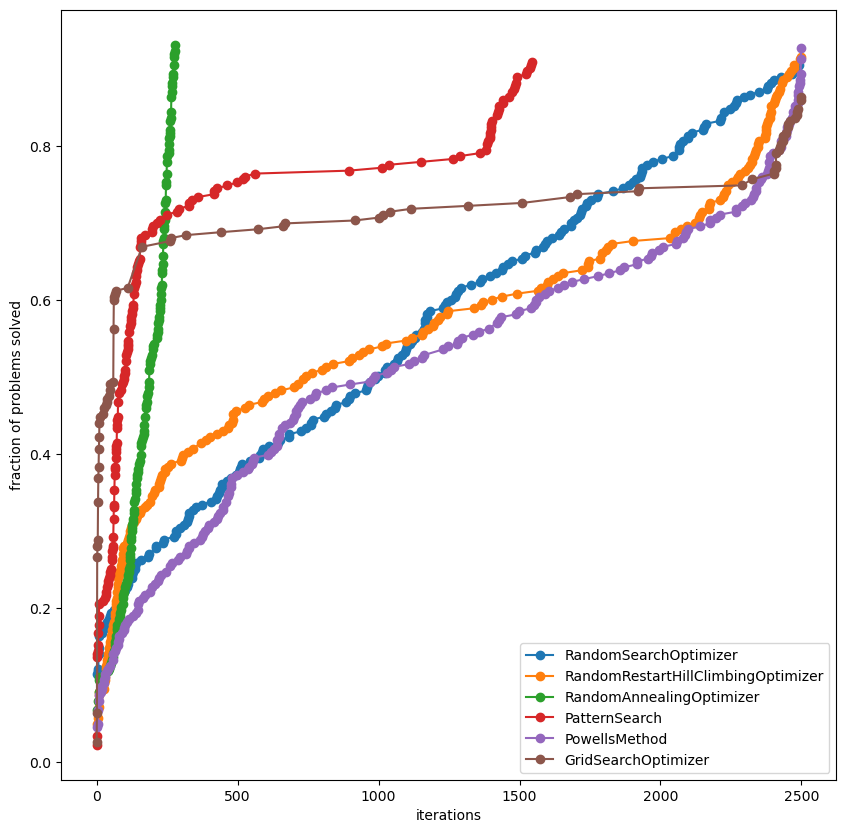

In [10]:
plot_sol_results(problems,global_solutions,"global_solutions_randomstart.png")

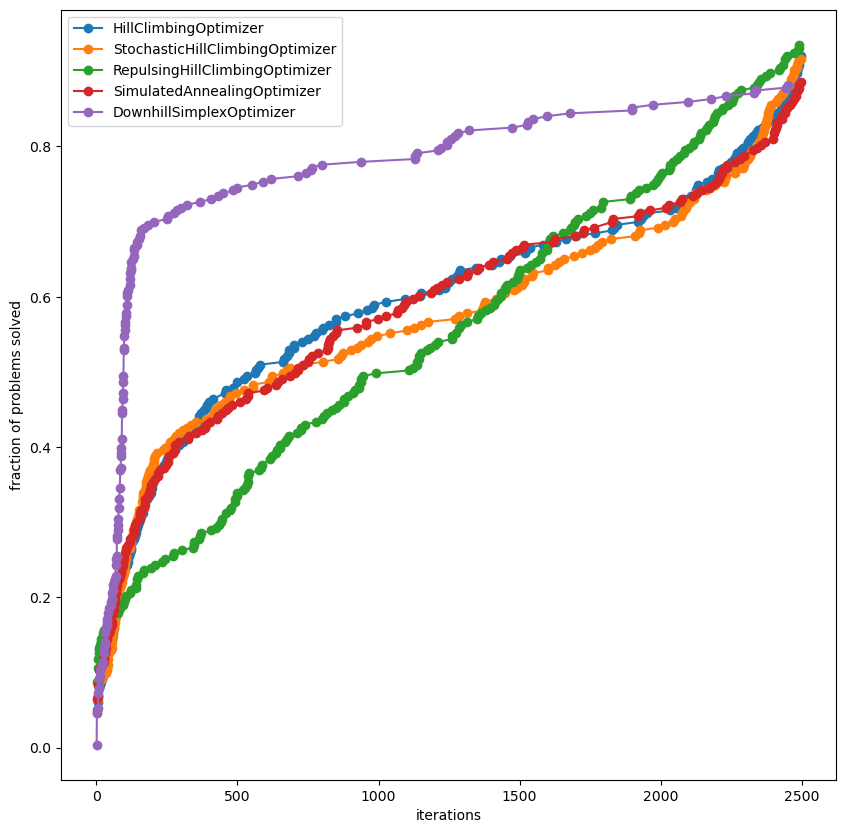

In [11]:
plot_sol_results(problems,local_solutions,"local_solutions_randomstart.png")

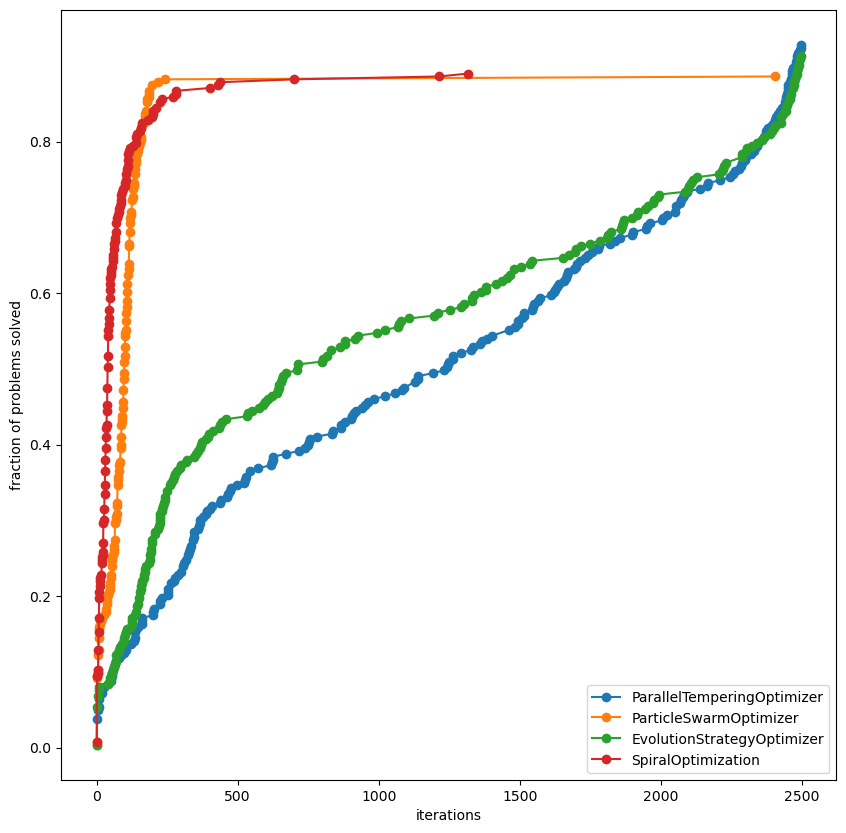

In [12]:
plot_sol_results(problems,pop_solutions,"pop_solutions_randomstart.png")

### Example code for Improving a given starting point.
- This code was actually run in parallel using command line inputs to accelerate results. the `opt_type` line was actually `sys.argv[1]` See included `data_gen.py` file for more details.

In [ ]:
import tqdm
import sys

all_valid_probs = bcp_valid_probs
all_valid_probs.sort()
all_opt = {'exp_opt':exp_opt,'global_opt':global_opt,'local_opt':local_opt,'pop_opt':pop_opt,'smb_opt':smb_opt}
opt_type = #input ("Enter optimization type (global, local, pop): ")
do_opt = all_opt[opt_type]
#taus = [1e-1,1e-2,1e-3,1e-6,0]
tmp_list = [f"{opt.__name__}\t" for opt in do_opt]+["f_x0"]
result_list = []
result_list += [''.join(tmp_list)]

for _prob in tqdm.tqdm(all_valid_probs, desc="Problems"):
    test_fxn = bcp[_prob]
    fxn_form = test_fxn['func']
    xlb = test_fxn['xlb']
    xub = test_fxn['xub']
    ndim = test_fxn['n']
    y_opt = test_fxn['yopt']
    x_opt = test_fxn['xopt']
    scales = [xub[i]-xlb[i] for i in range(ndim)]
    try:
        initial_guess = {str(i):np.random.normal(loc=x_opt[i],scale=scales[i]/3) for i in range(ndim)}
    except:
        tmp_list = []
        for i in range(len(do_opt)):
            tmp_list += [f"{np.nan}\t"]
        tmp_list += [f"{np.nan}"]
        result_list += [''.join(tmp_list)]
        continue
    x = initial_guess
    opt_form = get_usable_fxn(ndim, fxn_form)
    f_x0 = eval(opt_form)
    search_space = create_search_space(ndim, xlb, xub)
    parent_fxn = create_parent_fxn(search_space,opt_form)  
    medians = []
    for _opt in tqdm.tqdm(do_opt, desc="Optimizers"):
        f_solve = []
        #for i in range(10):
        opt = _opt(search_space, initialize={"warm_start":[initial_guess]})
        with open('initial_guesses','a') as tmp_f:
            print(initial_guess,file=tmp_f)
        try:
            opt.search(parent_fxn, n_iter=2500, verbosity=[False,False,False])
            f_solve.append(opt.best_score)
            f_solve.sort()
            median = np.median(f_solve)
            median = -1*median
            medians.append(median)
        except:
            medians.append(np.nan)
    tmp_list = [f"{_med}\t" for _med in medians]+[f"{f_x0}"]
    result_list += [''.join(tmp_list)]
with open(f"GivenSP_{opt_type}_Results.txt",'w') as f:
    f.write('\n'.join(result_list))

### Analyze and plot results

In [ ]:
global_results, local_results, pop_results = np.genfromtxt('GivenSP_global_opt_Results.txt', delimiter='\t')\
    ,np.genfromtxt('GivenSP_local_opt_Results.txt', delimiter='\t')\
    ,np.genfromtxt('GivenSP_pop_opt_Results.txt', delimiter='\t')



opt = [bcp[i]['yopt'] for i in all_valid_probs]

def get_results_tau(taus,f_x0,f_l, results, optimizers):
    comp = (f_x0 - results)/(f_x0 - f_l)
    solver_results = {optimizers[i].__name__:[] for i in range(len(optimizers))}
    for tau in taus:
        test = comp >= (1-tau)
        frac_comp = np.sum(test, axis=0)/test.shape[0]
        for i in range(len(optimizers)):
            solver_results[optimizers[i].__name__] += [frac_comp[i]]
    return solver_results



taus = [1e-1,1e-2,1e-4,1e-6,0.0]
f_x0 = global_results[1:,-1].reshape(-1,1)
f_l = np.array(opt).reshape(-1,1)
results = global_results[1:,:-1]
global_return_results = get_results_tau(taus,f_x0,f_l, results, global_opt)
f_x0 = local_results[1:,-1].reshape(-1,1)
local_return_results = get_results_tau(taus,f_x0,f_l, local_results[1:,:-1], local_opt)
f_x0 = pop_results[1:,-1].reshape(-1,1)
pop_return_results = get_results_tau(taus,f_x0,f_l, pop_results[1:,:-1], pop_opt)



import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,1,figsize=(6,14), sharey=True)
final_results = [global_return_results,local_return_results,pop_return_results]
optimizers = [global_opt,local_opt,pop_opt]
titles = ['Global','Local','Population']
for i in range(3):
    current_dict = final_results[i]
    for k in range(len(current_dict.keys())):
        ax[i].semilogx(taus,current_dict[optimizers[i][k].__name__],label=optimizers[i][k].__name__)
    legendfig = plt.figure(figsize=(3,7))
    legendfig.legend(ax[i].get_legend_handles_labels()[0], ax[i].get_legend_handles_labels()[1],'center')
    legendfig.savefig('legend_{}.png'.format(i))
    ax[i].set_title(titles[i])
    ax[i].invert_xaxis()
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.text(0.5, 0.08, 'Tau', ha='center', va='center')
fig.text(0.1, 0.5, 'Fraction of Problems Solved', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.92, 'Fraction of Problems Solved vs Tau', ha='center', va='center')
plt.tight_layout()
fig.subplots_adjust(left=0.2)
fig.savefig('tau_results.png')

### Create and save tables of results

In [ ]:
import pandas as pd
pop_table = pd.DataFrame(pop_return_results)
local_table = pd.DataFrame(local_return_results)
global_table = pd.DataFrame(global_return_results)

import imgkit

def display_dataframe_with_sci_index(df):
    sci_index = df.index.map('{:.0e}'.format)
    formatted_df = df.copy()
    formatted_df.index = sci_index
    return formatted_df

def save_table_as_png(table, name):
    new_table = display_dataframe_with_sci_index(table)
    styled_df = new_table.style.background_gradient(axis=None, vmin=0, vmax=1, cmap="YlGnBu")
    # Convert the styled DataFrame to HTML
    html = styled_df.render()
    # Save the HTML as a PNG image
    imgkit.from_string(html, name)

global_table.set_index(pd.Index(taus),inplace=True)
save_table_as_png(global_table,'global_table.png')
local_table.set_index(pd.Index(taus),inplace=True)
save_table_as_png(local_table,'local_table.png')
pop_table.set_index(pd.Index(taus),inplace=True)
save_table_as_png(pop_table,'pop_table.png')

### Example code for Improving a near optimal starting point
- This file was also run as a .py file (included). This shows the additional code written necessary to run. Utilizes `ray` for parallelization. 

In [ ]:
def get_perturbed_solutions(test_fxn):

    """
    Returns perturbed optimal solutions for a given input problem 
    """

    dims = test_fxn['n']
    perturbed_solutions = []

    for dim in range(dims):
        opt = test_fxn['xopt'][dim]       
        perturbation = np.random.uniform(-5, 5) / 100
        if opt != 0.0: perturbed_solution = np.array([opt + opt*perturbation])
        else: perturbed_solution = np.array([perturbation])
        perturbed_solutions.append(perturbed_solution)

    return np.concatenate(perturbed_solutions)

def get_all_initial_guesses(names):

    """
    Returns perturbed initial guesses for all valid problems as a list of dicts
    """

    valid_problems, invalid_problems = get_valid_problems(names)
    all_initial_guesses = []

    for problem in valid_problems:
        test_fxn = bcp[f'{problem}']
        dims = test_fxn['n']
        perturbed_solution = get_perturbed_solutions(test_fxn).astype(float)
        optimal_solution = test_fxn['xopt'].astype(float)
        percent_diff = np.divide(abs(perturbed_solution - optimal_solution), abs(optimal_solution), 
                                out=np.zeros_like(optimal_solution), where=optimal_solution!=0) * 100.0
        assert max(percent_diff) <= 5 # we sampled perturbations from uniform(-5,5)
        assert len(perturbed_solution) == dims

        initial_guess = {str(i):perturbed_solution[i] for i in range(dims)}
        all_initial_guesses.append(initial_guess)

    return all_initial_guesses, valid_problems, invalid_problems


def get_solutions(problems, solvers, all_initial_guesses):

    names = list(bcp.keys())
    final_solns = {}

    
    for problem in problems:

        try:
            test_fxn = bcp[f'{problem}']
            fxn_form = test_fxn['func']
            xlb = test_fxn['xlb']
            xub = test_fxn['xub']
            ndim = test_fxn['n']

            opt_form = get_usable_fxn(ndim, fxn_form)
            search_space = create_search_space(ndim, xlb, xub, resolution=100)
            fxn = create_parent_fxn(search_space,opt_form)

            initial_guess = all_initial_guesses[names.index(f'{problem}')]
            initialize={"warm_start":[initial_guess]}

            optimum = {}
            for f in solvers:
                opt = f(search_space) # initialize optimizer
                opt.search(fxn, n_iter=2500) # run optimizer
                optimum[f.__name__] = opt.best_para

            opts = ['Solver\tOptimum']
            for i in optimum.keys():
                tmp_opt = optimum[i]
                opts += ['{}\t{}'.format(i,tmp_opt)]
            with open(f'./{problem}-refinement.txt', 'w') as f:
                print('\n'.join(opts),file=f)

            final_solns[f'{problem}'] = optimum

        except: # some additional unexpected failures (e.g., OverFlow errors)
            problems = list(filter(lambda s: not (s[:]==f"{problem}"), problems))
            continue

    successful_problems = problems

    return final_solns, successful_problems


def get_solver_names(solvers):

    """ 
    Function to process strings of solvers
    """

    solver_names = []
    for i in range(len(solvers)):
        solver_name = str(solvers[i])
        # All solver names are after 4th "." 
        idx = solver_name.find(".", solver_name.find(".", solver_name.find(".", solver_name.find(".") + 1) + 1) + 1)

        # Select the substring after the 4th dot
        solver_name = solver_name[idx+1:]
        solver_name = solver_name.replace("'", "")
        solver_name = solver_name.replace(">", "")
        solver_names.append(solver_name)
    
    return solver_names

def get_maes(problems, solver_names, solver_solutions):

    """
    Get MAEs for a list of specified problems, ground truth solutions, and solution obtained
    by a list of solvers
    """
    from sklearn.metrics import mean_absolute_error

    maes = {}

    for solver_name in solver_names:
        solver_opts = [v[f'{solver_name}'] for v in solver_solutions.values()]
        true_opts = [bcp[f'{problem}']['yopt'] for problem in problems]
        mae = mean_absolute_error(solver_opts, true_opts)
        maes[f'{solver_name}'] = mae

    return maes

def create_function(problem_idx, func_string, valid_problems, invalid_problems):
    """
    Weird function to obtain an actual python function we can evaluate given inputs.
    I wrote this because I was unaware of the built in package evaluation
    """
    filtered_bcp = {key: value for key, value in bcp.items() if not any(s in key for s in invalid_problems)}

    for i in range(len(filtered_bcp[valid_problems[problem_idx]]['xopt'])):
        func_string = func_string.replace(f"x[:,{i}]",f"x[{str(i)}]")

    function_def = "def problem_function(x):\n    return " + func_string
    exec(function_def, globals())

    return globals()['problem_function']

def get_x_values(initial_guesses):
    """ 
    Convert initial guesses from dict to list for input to function
    """
    x = []
    for value in initial_guesses.values():
        x.append(value)
    return x

def evaluate_refinement(problems, solver_names, all_initial_guesses, solver_solutions, valid_problems, invalid_problems, taus):

    """
    Evaluate the refinement according to the equation from the paper
    """

    filtered_bcp = {key: value for key, value in bcp.items() if not any(s in key for s in invalid_problems)}

    for problem in problems:
        for solver in solver_names:          
            func_string = filtered_bcp[problem]['func'] 
            problem_idx = list(filtered_bcp.keys()).index(problem)
            initial_guesses = all_initial_guesses[problem_idx]
            initial_guesses  = get_x_values(initial_guesses)
            problem_function = create_function(problem_idx, func_string, valid_problems, invalid_problems)
            f_x0 = problem_function(initial_guesses)
            solver_output = solver_solutions[problem][solver]
            solver_output  = get_x_values(solver_output)
            f_solver = problem_function(solver_output)
            f_L = filtered_bcp[problem]['yopt']

            success = []

            for j in range(len(taus)):
                try:
                    assert f_x0 - f_solver >= (1 - taus[j])*(f_x0 - f_L)
                    success.append("successful")
                except:
                    success.append("not successful")
                    pass

            solver_solutions[problem][solver] = success
    
    return solver_solutions

def get_plot_dict(problems, solver_solutions, solver_names, taus):

    """
    Get results in format for plotting
    """

    # New dictionary more intuitive in ordering 
    # Note to self: This is ugly ugly ugly code
    solver_solutions_inverted = {}

    for outer_key, inner_dict in solver_solutions.items():
        for inner_key, value in inner_dict.items():
            if inner_key not in solver_solutions_inverted:
                solver_solutions_inverted[inner_key] = {}
            solver_solutions_inverted[inner_key][outer_key] = value

    solver_solutions = solver_solutions_inverted 
    plot_dict = {}

    for solver in solver_names:
        num_successfuls = [0] * len(taus)
        for inner_list in solver_solutions[solver].values():
            for i, value in enumerate(inner_list):
                if value == 'successful':
                    num_successfuls[i] += 1

        fraction = [x / len(problems) for x in num_successfuls]
        plot_dict[solver] = fraction

    return plot_dict

@ray.remote
def run_refinement(problems, solvers, all_initial_guesses, valid_problems, invalid_problems, taus):

    solver_names = get_solver_names(solvers)
    solver_solutions, successful_problems = get_solutions(problems, solvers, all_initial_guesses)
    solver_refinement = evaluate_refinement(successful_problems, solver_names, all_initial_guesses, solver_solutions, valid_problems, invalid_problems, taus)
    plot_dict = get_plot_dict(successful_problems, solver_refinement, solver_names, taus)

    with open('./successful-problems.txt','w') as tfile:
        tfile.write('\n'.join(successful_problems))

    return plot_dict

def run_refinement_local(problems, solvers, all_initial_guesses, valid_problems, invalid_problems, taus):

    solver_names = get_solver_names(solvers)
    solver_solutions, successful_problems = get_solutions(problems, solvers, all_initial_guesses)
    solver_refinement = evaluate_refinement(successful_problems, solver_names, all_initial_guesses, solver_solutions, valid_problems, invalid_problems, taus)
    plot_dict = get_plot_dict(successful_problems, solver_refinement, solver_names, taus)

    with open('./successful-problems.txt','w') as tfile:
        tfile.write('\n'.join(successful_problems))

    return plot_dict


if __name__ == "__main__":

    global_opt = [RandomSearchOptimizer,RandomRestartHillClimbingOptimizer,RandomAnnealingOptimizer,PatternSearch,PowellsMethod,GridSearchOptimizer]
    local_opt = [HillClimbingOptimizer,StochasticHillClimbingOptimizer,RepulsingHillClimbingOptimizer,SimulatedAnnealingOptimizer,DownhillSimplexOptimizer]
    pop_opt = [ParallelTemperingOptimizer,ParticleSwarmOptimizer,EvolutionStrategyOptimizer,SpiralOptimization]

    names = list(bcp.keys())
    all_initial_guesses, valid_problems, invalid_problems = get_all_initial_guesses(names)
    problems = valid_problems
    solvers = [global_opt,local_opt,pop_opt]

    taus = [1e-3, 1e-4, 1e-5, 1e-7, 0e+0]

    try:
        ray.init()
    except RuntimeError: # cluster is already initialized
        pass
    
    futures = [run_refinement.remote(problems, solvers[i], all_initial_guesses, valid_problems, invalid_problems, taus) for i in range(len(solvers))]
    plot_dicts = ray.get(futures)

    with open('./dicts-all.txt', 'w') as convert_file:
        convert_file.write(json.dumps(plot_dicts))

### Analyze and plot results

In [ ]:


import json
import matplotlib.pyplot as plt
import numpy as np

with open('./dicts-all.txt', 'r') as f:
    contents = f.read() # or f.readlines()

dicts_list = json.loads(contents)
dict = dicts_list[0] 

fig, ax = plt.subplots()

taus = [1e-3, 1e-4, 1e-5, 1e-7, 0e+0]
n_lines = len(dict)

for i, (label, y) in enumerate(dict.items()):
    ax.plot(taus, y, 'o-', label=label)

ax.set_xlabel('tau')

plt.title(f"Refinement Ability")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.invert_xaxis()
ax.set_ylabel('Fraction of Problems')

# Move the legend to the right of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Save the figure with a higher resolution
plt.savefig("./final-plot-1.png", dpi=500)

dict = dicts_list[1] 

fig, ax = plt.subplots()

taus = [1e-3, 1e-4, 1e-5, 1e-7, 0e+0]
n_lines = len(dict)

for i, (label, y) in enumerate(dict.items()):
    ax.plot(taus, y, 'o-', label=label)

ax.set_xlabel('tau')

plt.title(f"Refinement Ability")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.invert_xaxis()
ax.set_ylabel('Fraction of Problems')

# Move the legend to the right of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Save the figure with a higher resolution
plt.savefig("./final-plot-2.png", dpi=500)



dict = dicts_list[2] 

fig, ax = plt.subplots()

taus = [1e-3, 1e-4, 1e-5, 1e-7, 0e+0]
n_lines = len(dict)

for i, (label, y) in enumerate(dict.items()):
    ax.plot(taus, y, 'o-', label=label)

ax.set_xlabel('tau')

plt.title(f"Refinement Ability")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.invert_xaxis()
ax.set_ylabel('Fraction of Problems')

# Move the legend to the right of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Save the figure with a higher resolution
plt.savefig("./final-plot-3.png", dpi=500)